In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns

from numpy                   import isnan
from IPython.core.display    import HTML
from IPython.display         import Image
from tabulate                import tabulate
from sklearn.preprocessing   import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy                   import stats  as ss
from sklearn.impute          import KNNImputer

import matplotlib.pyplot     as plt
import plotly.express        as px

# 0.0 Imports

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.rcParams['font.size'] = 15
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
def cramer_v (x,y):

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k -1)**2/(n-1)
    rcorr = r - (r -1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loanding Data

In [4]:
df_flu_feat = pd.read_csv("training_set_features.csv", index_col = False, low_memory = False)
df_flu_label = pd.read_csv("training_set_labels.csv", index_col = False, low_memory = False)

In [5]:
df_flu_feat.sample(5)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
13653,13653,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,2.0,1.0,5.0,5.0,1.0,5.0,18 - 34 Years,Some College,Black,Female,"<= $75,000, Above Poverty",Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",0.0,1.0,NaN,NaN
2149,2149,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,3.0,2.0,4.0,3.0,2.0,1.0,35 - 44 Years,Some College,White,Male,NaN,Married,NaN,NaN,fpwskwrf,"MSA, Not Principle City",1.0,0.0,NaN,NaN
11196,11196,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0,4.0,1.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,"MSA, Not Principle City",0.0,0.0,NaN,NaN
11072,11072,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,4.0,4.0,4.0,4.0,45 - 54 Years,12 Years,White,Male,"<= $75,000, Above Poverty",Married,Own,Employed,dqpwygqj,"MSA, Not Principle City",2.0,1.0,rucpziij,xtkaffoo
17669,17669,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,5.0,2.0,4.0,5.0,5.0,4.0,45 - 54 Years,Some College,Hispanic,Female,NaN,Married,Own,Employed,mlyzmhmf,Non-MSA,1.0,0.0,wxleyezf,emcorrxb


# 1.0 Data Descriptive

In [6]:
df1 = df_flu_feat.copy()

In [7]:
df1 = df1.drop(['hhs_geo_region', 'employment_industry', 'employment_occupation', 'health_insurance'], axis = 1)

# 1.1 Data Dimensions

In [8]:
print ('Number of Rows: {}'.format( df1.shape[0]))
print ('Number of Cols: {}'.format (df1.shape[1]))

Number of Rows: 26707
Number of Cols: 32


# 1.2 Data Types

In [9]:
a = df1.dtypes

In [10]:
a

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

# 1.3 Check NA

In [11]:
null = df1.isnull().sum()#/df1.shape[0] * 100

In [12]:
null

respondent_id                     0
h1n1_concern                     92
h1n1_knowledge                  116
behavioral_antiviral_meds        71
behavioral_avoidance            208
behavioral_face_mask             19
behavioral_wash_hands            42
behavioral_large_gatherings      87
behavioral_outside_home          82
behavioral_touch_face           128
doctor_recc_h1n1               2160
doctor_recc_seasonal           2160
chronic_med_condition           971
child_under_6_months            820
health_worker                   804
opinion_h1n1_vacc_effective     391
opinion_h1n1_risk               388
opinion_h1n1_sick_from_vacc     395
opinion_seas_vacc_effective     462
opinion_seas_risk               514
opinion_seas_sick_from_vacc     537
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
marital_status                 1408
rent_or_own                 

# 1.4 Fillout NA

In [13]:
#age_group
age_group_dict = {'18 - 34 Years':0 ,'35 - 44 Years':1 ,'45 - 54 Years':2 , '55 - 64 Years':3, '65+ Years':4}
df1['age_group'] = df1['age_group'].map( age_group_dict )

#education
educ_dict = {'< 12 Years':0 ,'12 Years':1 ,'Some College':2 ,'College Graduate':3 }
df1['education'] = df1['education'].map( educ_dict )

#race
race_dict = {'White':0 ,'Black':1 ,'Hispanic':2 , 'Other or Multiple':3 }
df1['race'] = df1['race'].map( race_dict )

#sex
sex_dict = {'Female':0 ,'Male':1}
df1['sex'] = df1['sex'].map( sex_dict )

#income_poverty
income_poverty_dict = {'Below Poverty':0 ,'<= $75,000, Above Poverty':1 ,'> $75,000':2 }
df1['income_poverty'] = df1['income_poverty'].map( income_poverty_dict )

#marital_status
marital_status_dict = {'Married':0 ,'Not Married':1}
df1['marital_status'] = df1['marital_status'].map( marital_status_dict )

#rent_or_own
rent_or_own_dict = {'Own':0 ,'Rent':1}
df1['rent_or_own'] = df1['rent_or_own'].map( rent_or_own_dict )

#employment_status
employment_dict = {'Employed':0 ,'Not in Labor Force':1, 'Unemployed':2}
df1['employment_status'] = df1['employment_status'].map( employment_dict )

#census_msa
census_msa_dict = {'MSA, Principle City':0 ,'MSA, Not Principle  City':1, 'Non-MSA':2}
df1['census_msa'] = df1['census_msa'].map( census_msa_dict )

In [14]:
imputer = KNNImputer()
df1 = pd.DataFrame(imputer.fit_transform(df1), columns = df1.columns)

In [15]:
df1 = df1.apply(lambda x: x.astype('int64'))

In [16]:
#age_group
age_group_dict = {0:'18 - 34 Years' ,1:'35 - 44 Years' ,2:'45 - 54 Years' , 3:'55 - 64 Years', 4:'65+ Years' }
df1['age_group'] = df1['age_group'].map( age_group_dict )

#education
educ_dict = {0:'< 12 Years' ,1:'12 Years' ,2:'Some College' ,3:'College Graduate' }
df1['education'] = df1['education'].map( educ_dict )

#race
race_dict = {0:'White' ,1:'Black' ,2:'Hispanic' , 3:'Other or Multiple' }
df1['race'] = df1['race'].map( race_dict )

#sex
sex_dict = {0:'Female' ,1:'Male'}
df1['sex'] = df1['sex'].map( sex_dict )

#income_poverty
income_poverty_dict = {0:'Below Poverty' ,1:'<= $75,000, Above Poverty' ,2:'> $75,000' }
df1['income_poverty'] = df1['income_poverty'].map( income_poverty_dict )

#marital_status
marital_status_dict = {0:'Married' ,1:'Not Married'}
df1['marital_status'] = df1['marital_status'].map( marital_status_dict )

#rent_or_own
rent_or_own_dict = {0:'Own' ,1:'Rent'}
df1['rent_or_own'] = df1['rent_or_own'].map( rent_or_own_dict )

#employment_status
employment_dict = {0:'Employed' ,1:'Not in Labor Force', 2:'Unemployed'}
df1['employment_status'] = df1['employment_status'].map( employment_dict )

#census_msa
census_msa_dict = {0:'MSA, Principle City' ,1:'MSA, Not Principle  City', 2:'Non-MSA'}
df1['census_msa'] = df1['census_msa'].map( census_msa_dict )

# 1.5 Descriptive Statistical

In [17]:
num_att = df1.select_dtypes( include = ['int64', 'float64'])
cat_att = df1.select_dtypes( exclude = ['int64', 'float64'])

# 1.5.1 Numerical Attributes

In [18]:
num_att.describe().T

,count,mean,std,min,25%,50%,75%,max
respondent_id,26707.0,13353.000000,7709.791156,0.0,6676.5,13353.0,20029.5,26706.0
h1n1_concern,26707.0,1.616767,0.909699,0.0,1.0,2.0,2.0,3.0
h1n1_knowledge,26707.0,1.261018,0.617509,0.0,1.0,1.0,2.0,2.0
behavioral_antiviral_meds,26707.0,0.048714,0.215273,0.0,0.0,0.0,0.0,1.0
behavioral_avoidance,26707.0,0.721384,0.448327,0.0,0.0,1.0,1.0,1.0
behavioral_face_mask,26707.0,0.068933,0.253345,0.0,0.0,0.0,0.0,1.0
behavioral_wash_hands,26707.0,0.824877,0.380079,0.0,1.0,1.0,1.0,1.0
behavioral_large_gatherings,26707.0,0.357472,0.479264,0.0,0.0,0.0,1.0,1.0
behavioral_outside_home,26707.0,0.336279,0.472444,0.0,0.0,0.0,1.0,1.0
behavioral_touch_face,26707.0,0.674767,0.468471,0.0,0.0,1.0,1.0,1.0


# 1.5.2 Categorical Attributes

In [19]:
cat_att.describe().T

,count,unique,top,freq
age_group,26707,5,65+ Years,6843
education,26707,4,College Graduate,10117
race,26707,4,White,21222
sex,26707,2,Female,15858
income_poverty,26707,3,"<= $75,000, Above Poverty",16647
marital_status,26707,2,Married,14929
rent_or_own,26707,2,Own,20778
employment_status,26707,3,Employed,14922
census_msa,26707,3,"MSA, Not Principle City",11645


# 2.0 Feature Engineering

In [20]:
df2 = df1.copy()

# 2.1 Mapa Mental de Hipóteses

In [21]:
a = Image ('img/Flu_Shot_Map_Mind.png')

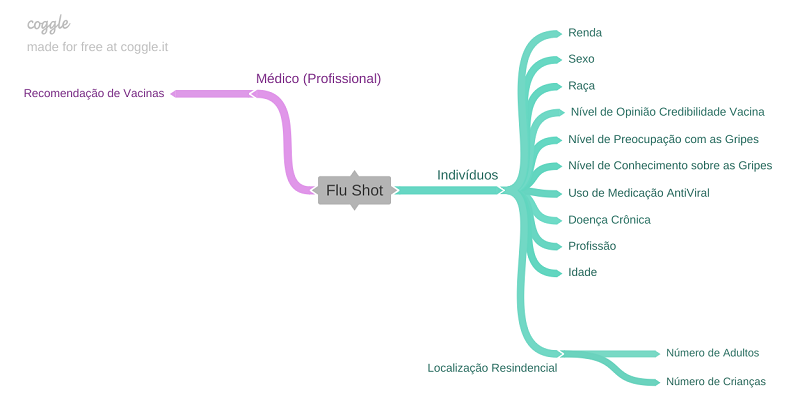

In [22]:
a

# 2.2 Criação das Hipóteses

**1.** Indivíduos mais jovens tendem a vacinar-se mais

**2.** Indivíduos com doenças crônicas tendem a vacinar-se mais

**3.** Profissionais da saúde tendem a vacinar-se mais

**4.** Mulheres tendem a vacinar-se mais

**5.** Indivíduos tendem a vacinar-se mais contra gripes sazonais 

**6.** Indivíduos com renda renda maior que $75,000 anual tendem a vacinar-se mais

**7.** Indivíduos que residem na região metropolitana tendem a vacinar-se mais

**8.** Indivíduos que residem com uma quantidade maior de crianças em casa tendem a vacinar-se mais

**9.** Indivíduos que residem com uma quantidade maior de adultos em casa tendem a vacinar-se menos

**10.** Indivíduos empregados tendem a vacinar-se mais

**11.** Indivíduos tendem a vacinar-se mais quando recomendadas pelos médicos

**12.** Indivíduos com maior acesso à educação tendem a vacinar-se mais

**13.** Indivíduos que tem o costume de usar máscara tendem a vacinar-se mais

**14.** Indivíduos com "Nível de Preocupação" menor quanto a contrair gripes tendem a vacinar-se menos

**15.** Indivíduos que utilizam medicações antivirais tendem a vacinar-se mais

# 3.0 Análise Exploratória de Dados

In [23]:
df3 = df2.copy()

In [24]:
# Merge

df3 = pd.merge(df3,df_flu_label, on = 'respondent_id' )

# 3.1 Análise Univariada

In [25]:
num_attributes = df3.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df3.select_dtypes( exclude = ['int64', 'float64'])

## 3.1.1 Response Variable

Text(0, 0.5, 'seasonal_vaccine')

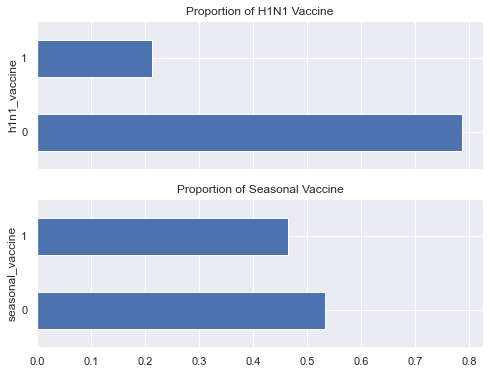

In [26]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.rcParams['figure.figsize'] = [10, 5]

num = df_flu_label.shape[0]

(df_flu_label['h1n1_vaccine']
    .value_counts()
    .div(num)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel('h1n1_vaccine')


(df_flu_label['seasonal_vaccine']
    .value_counts()
    .div(num)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel('seasonal_vaccine')

## 3.1.2 Numerical Variable

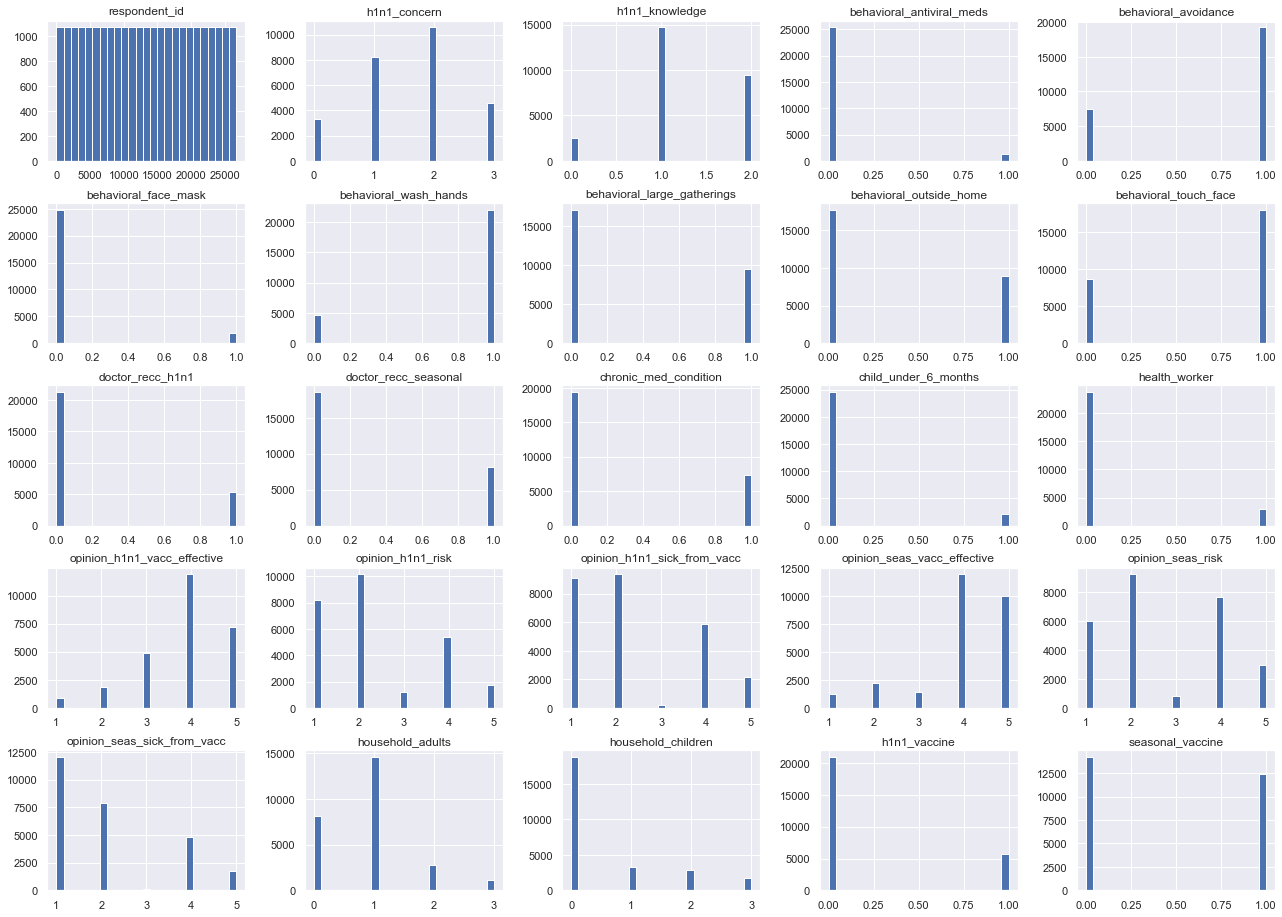

In [27]:
plt.rcParams['figure.figsize'] = [22, 16]
num_attributes.hist(bins = 25);

## 3.1.3 Categorical Variable

In [28]:
cat_attributes.describe().T

,count,unique,top,freq
age_group,26707,5,65+ Years,6843
education,26707,4,College Graduate,10117
race,26707,4,White,21222
sex,26707,2,Female,15858
income_poverty,26707,3,"<= $75,000, Above Poverty",16647
marital_status,26707,2,Married,14929
rent_or_own,26707,2,Own,20778
employment_status,26707,3,Employed,14922
census_msa,26707,3,"MSA, Not Principle City",11645


<AxesSubplot:xlabel='education', ylabel='count'>

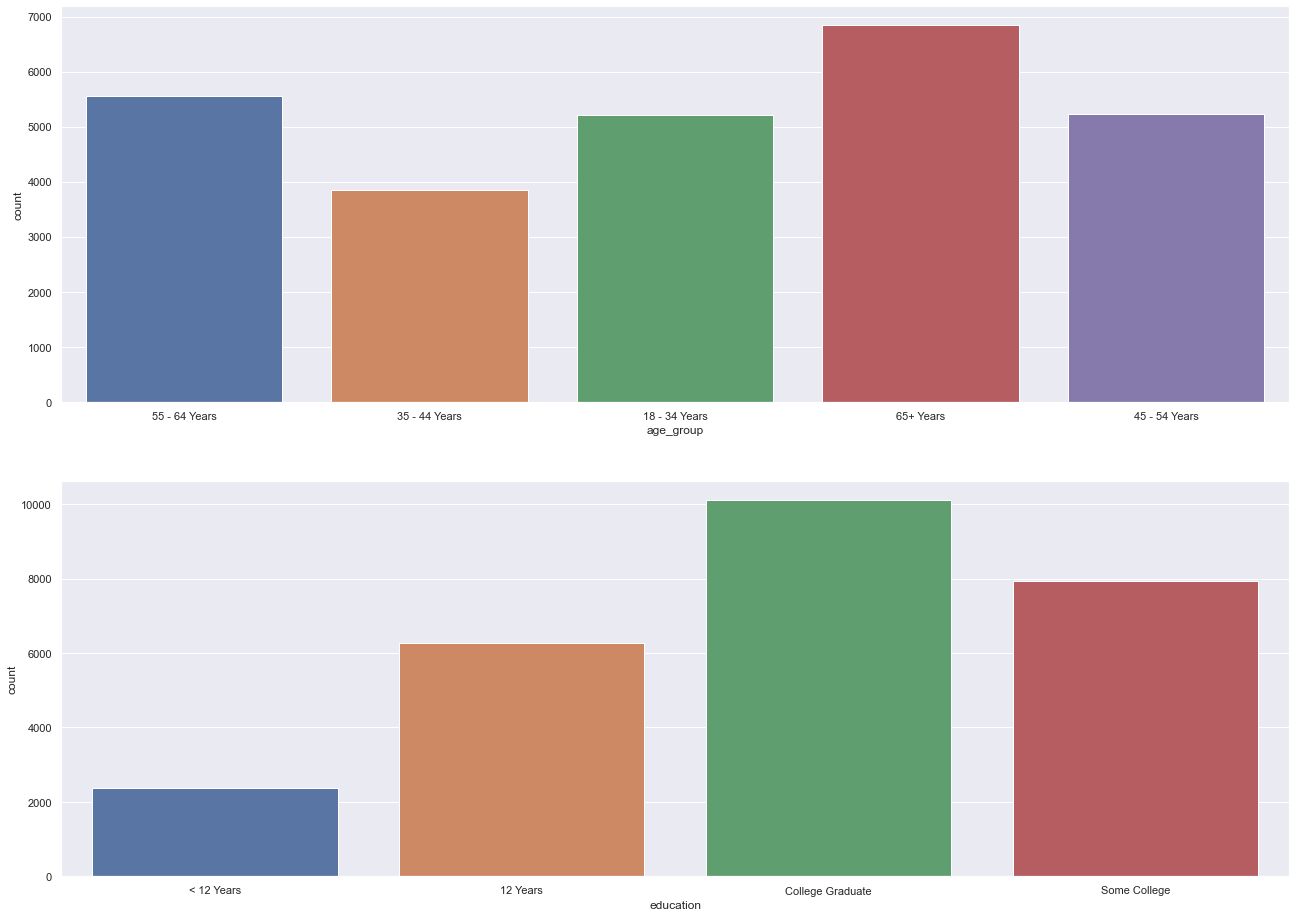

In [29]:
#age_group
plt.subplot (2,1,1)
sns.countplot(x = 'age_group', data = df3)


#education
plt.subplot (2,1,2)
sns.countplot(x = 'education', data = df3)

<AxesSubplot:xlabel='sex', ylabel='count'>

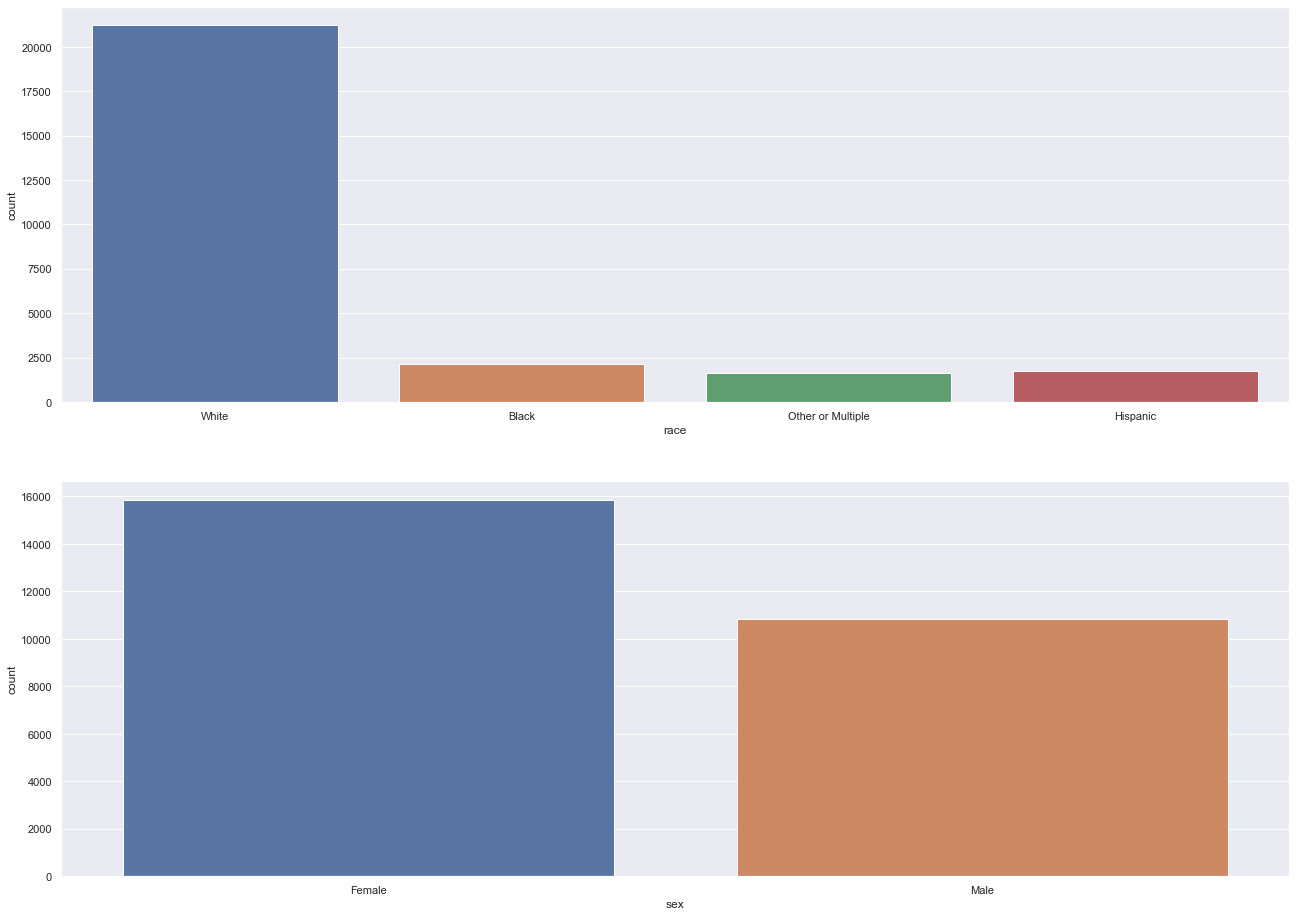

In [30]:
#race
plt.subplot (2,1,1)
sns.countplot(x = 'race', data = df3)

#sex
plt.subplot (2,1,2)
sns.countplot(x = 'sex', data = df3)

<AxesSubplot:xlabel='marital_status', ylabel='count'>

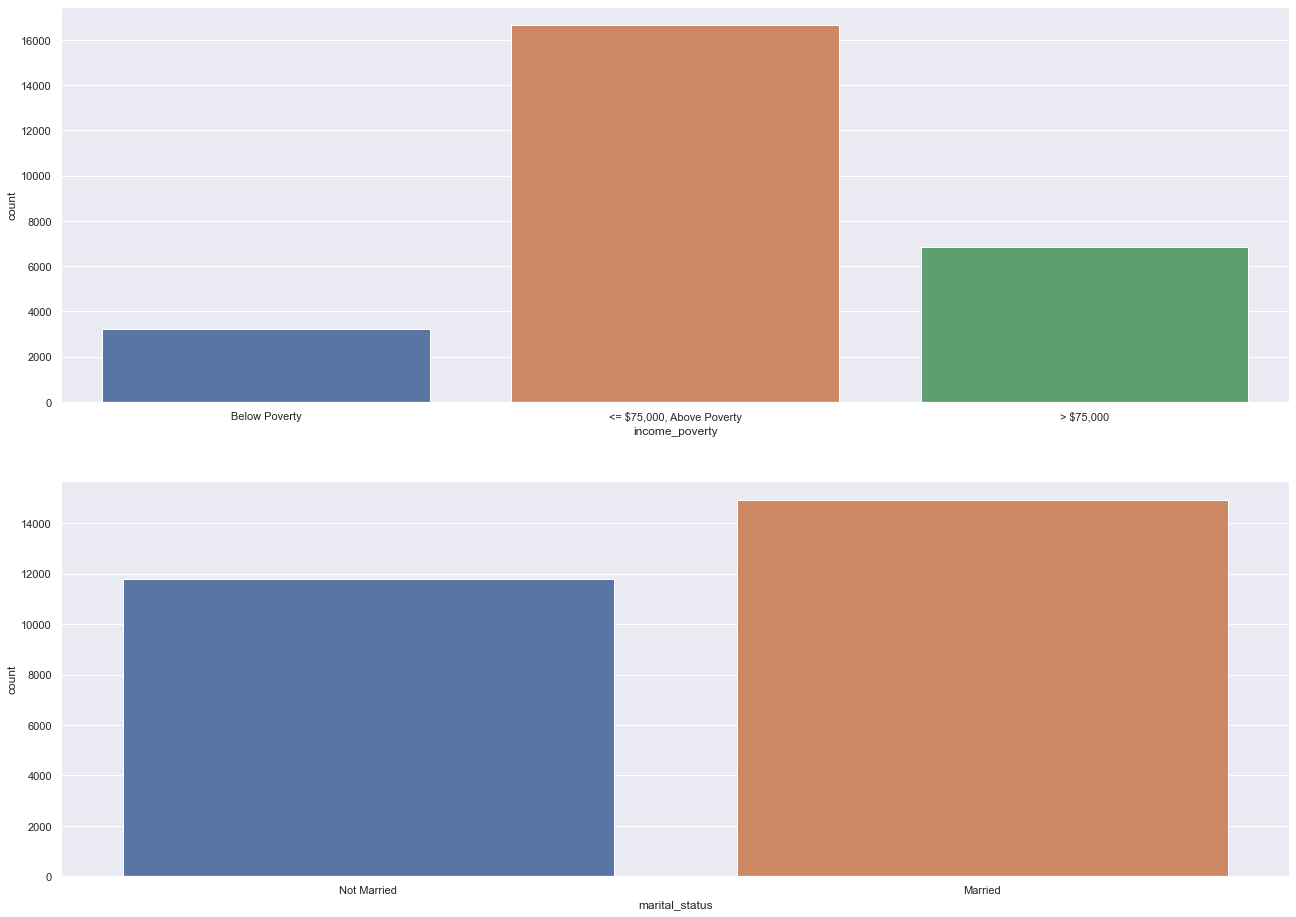

In [31]:
#income_poverty
plt.subplot (2,1,1)
sns.countplot(x = 'income_poverty', data = df3)

#marital_status
plt.subplot (2,1,2)
sns.countplot(x = 'marital_status', data = df3)

<AxesSubplot:xlabel='employment_status', ylabel='count'>

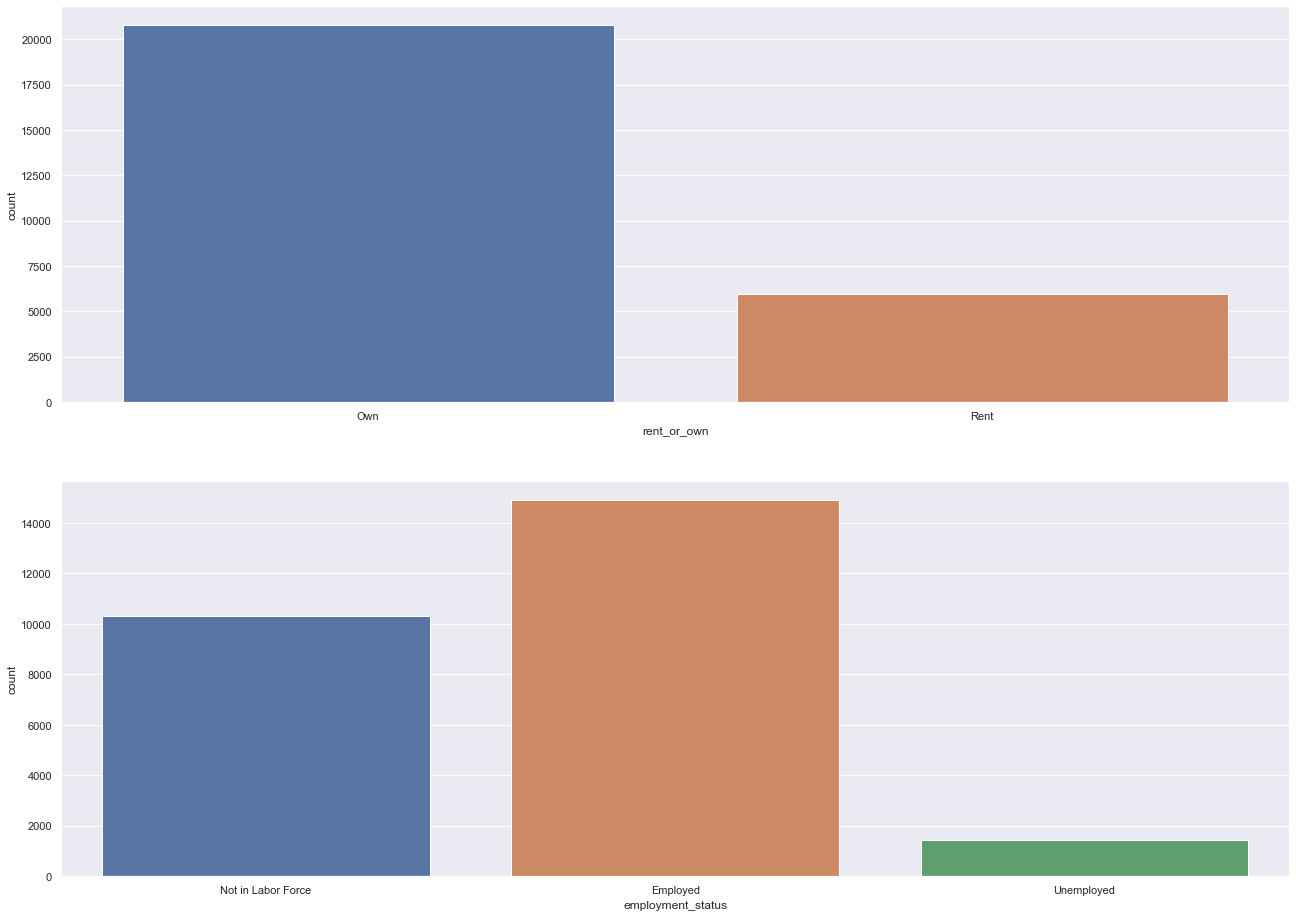

In [32]:
#rent_or_own
plt.subplot (2,1,1)
sns.countplot(x = 'rent_or_own', data = df3)

#employment_status
plt.subplot (2,1,2)
sns.countplot(x = 'employment_status', data = df3)

<AxesSubplot:xlabel='census_msa', ylabel='count'>

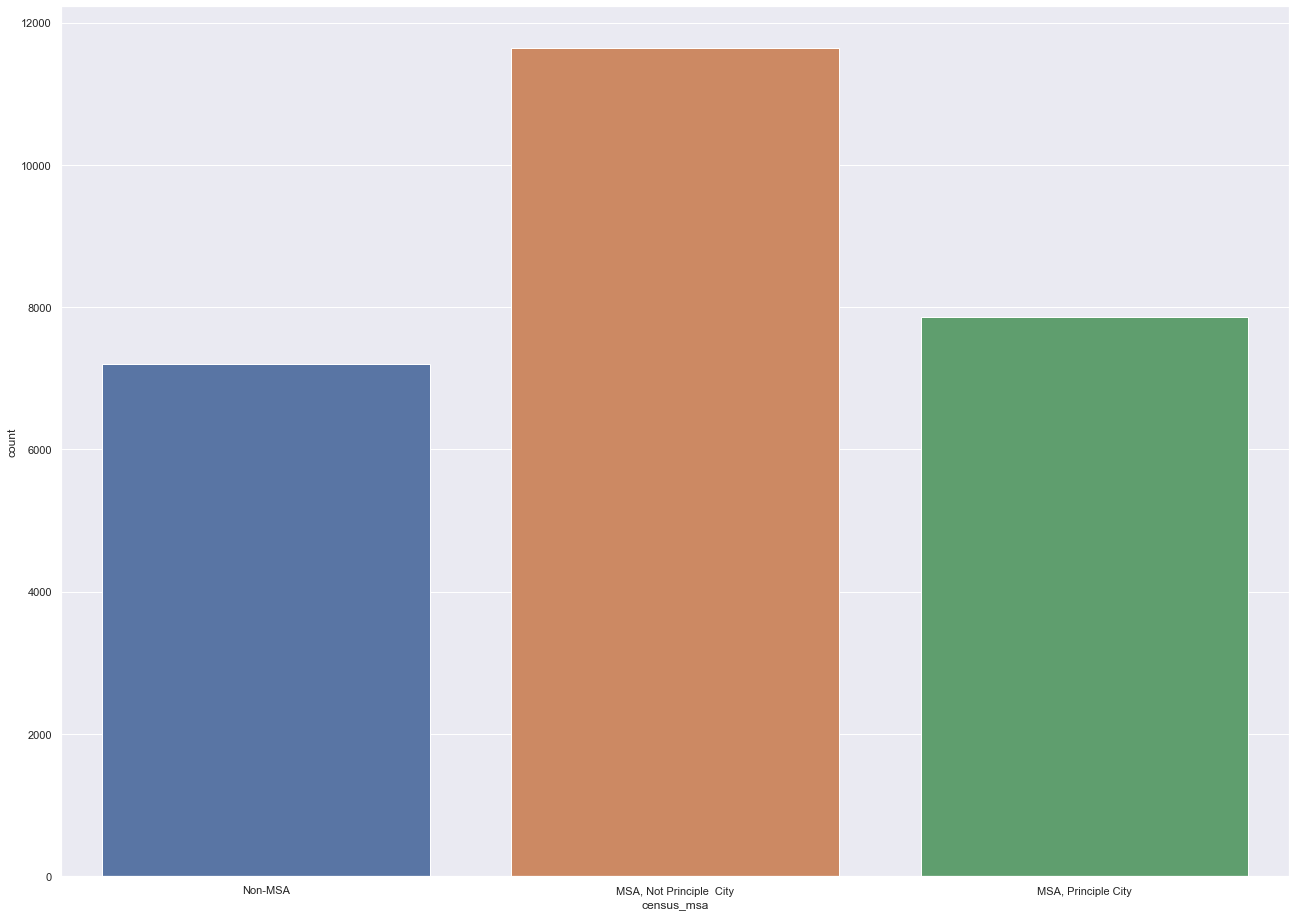

In [33]:
#census_msa
sns.countplot(x = 'census_msa', data = df3)

# 3.2 Análise Bivariada

## H1. Indivíduos mais jovens tendem vacinar-se mais

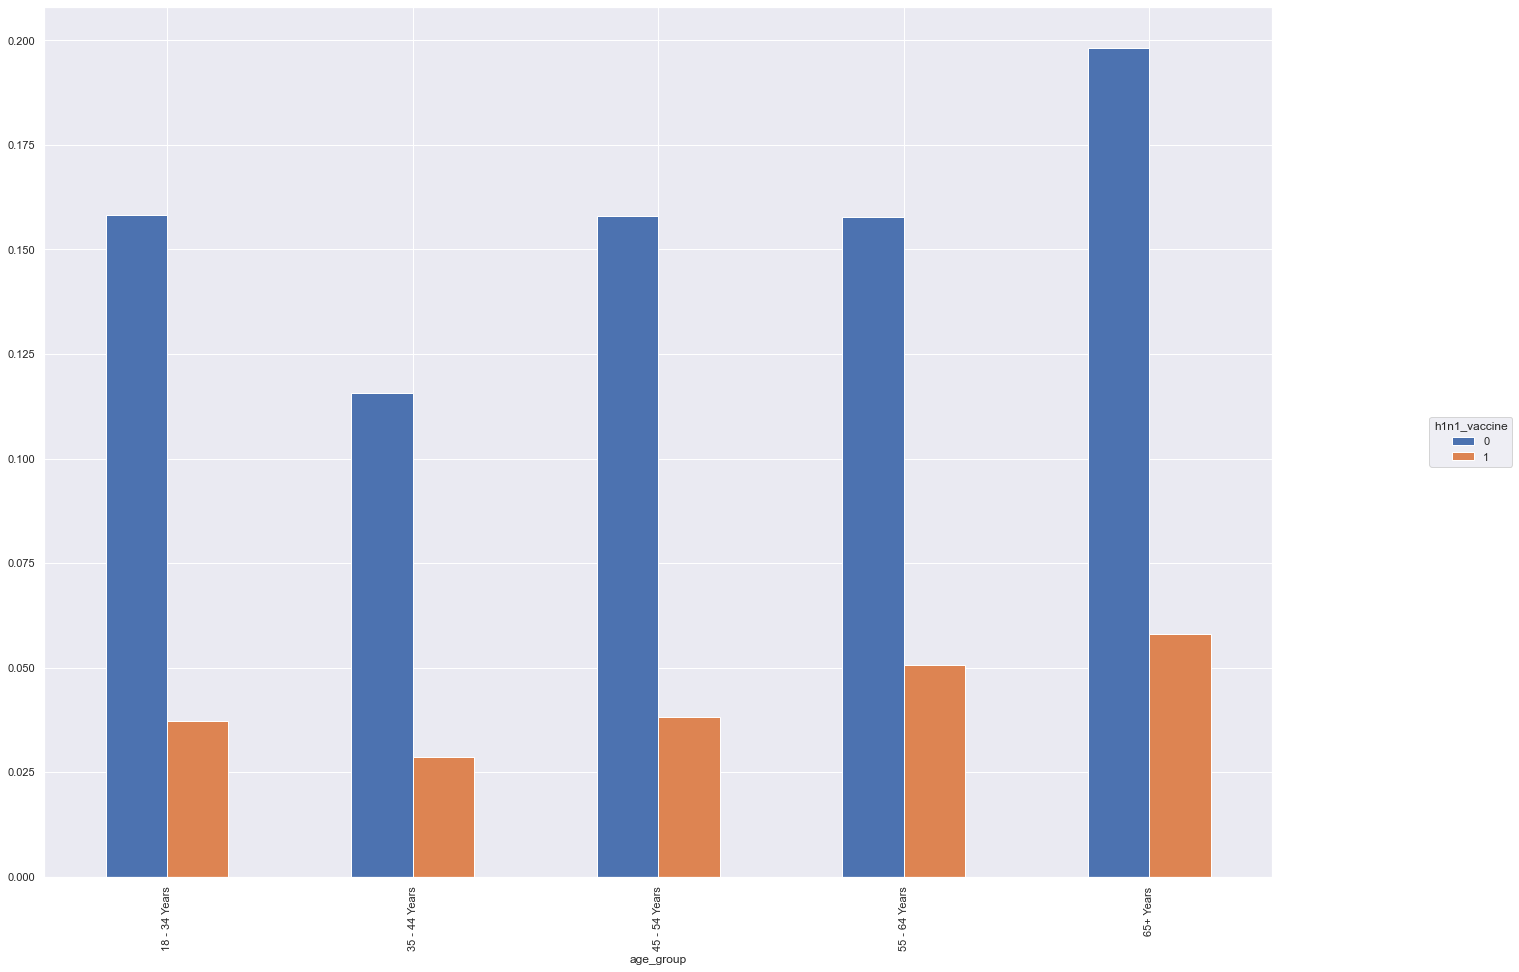

In [34]:
n_obs = df3.shape[0]

counts = (df3[['age_group','h1n1_vaccine']]
              .groupby(['age_group','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('h1n1_vaccine')
         )

ax = counts.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='h1n1_vaccine')

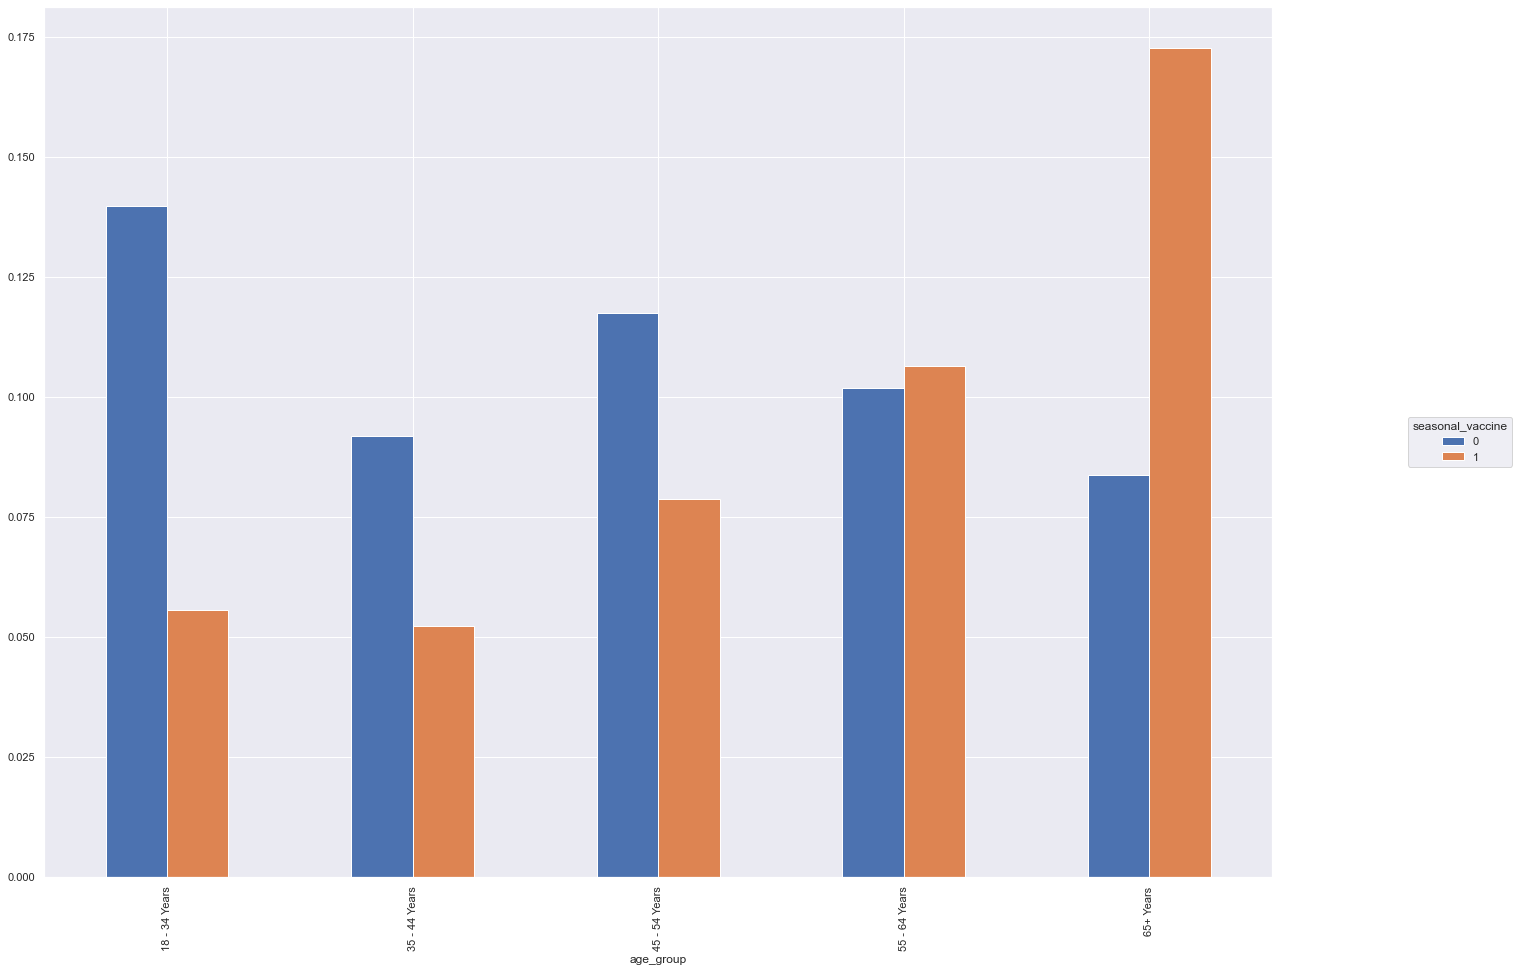

In [35]:
n_obs = df3.shape[0]

counts1 = (df3[['age_group','seasonal_vaccine']]
              .groupby(['age_group','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('seasonal_vaccine')
         )

ax = counts1.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='seasonal_vaccine')

In [36]:
counts['0 em %'] = counts[0]/(counts[0] + counts[1])*100
counts['1 em %'] = counts[1]/(counts[0] + counts[1])*100
counts

h1n1_vaccine,0,1,0 em %,1 em %
age_group,,,,
18 - 34 Years,0.158161,0.037106,80.997124,19.002876
35 - 44 Years,0.115588,0.028494,80.223493,19.776507
45 - 54 Years,0.157936,0.038192,80.526919,19.473081
55 - 64 Years,0.157711,0.050586,75.714543,24.285457
65+ Years,0.198150,0.058075,77.334502,22.665498


In [37]:
counts1['0 em %'] = counts1[0]/(counts1[0] + counts1[1])*100
counts1['1 em %'] = counts1[1]/(counts1[0] + counts1[1])*100
counts1

seasonal_vaccine,0,1,0 em %,1 em %
age_group,,,,
18 - 34 Years,0.139701,0.055566,71.543624,28.456376
35 - 44 Years,0.091849,0.052233,63.747401,36.252599
45 - 54 Years,0.117422,0.078706,59.870179,40.129821
55 - 64 Years,0.101809,0.106489,48.876505,51.123495
65+ Years,0.083611,0.172614,32.631887,67.368113


## H2. Indivíduos com doenças crônicas tendem vacinar-se mais

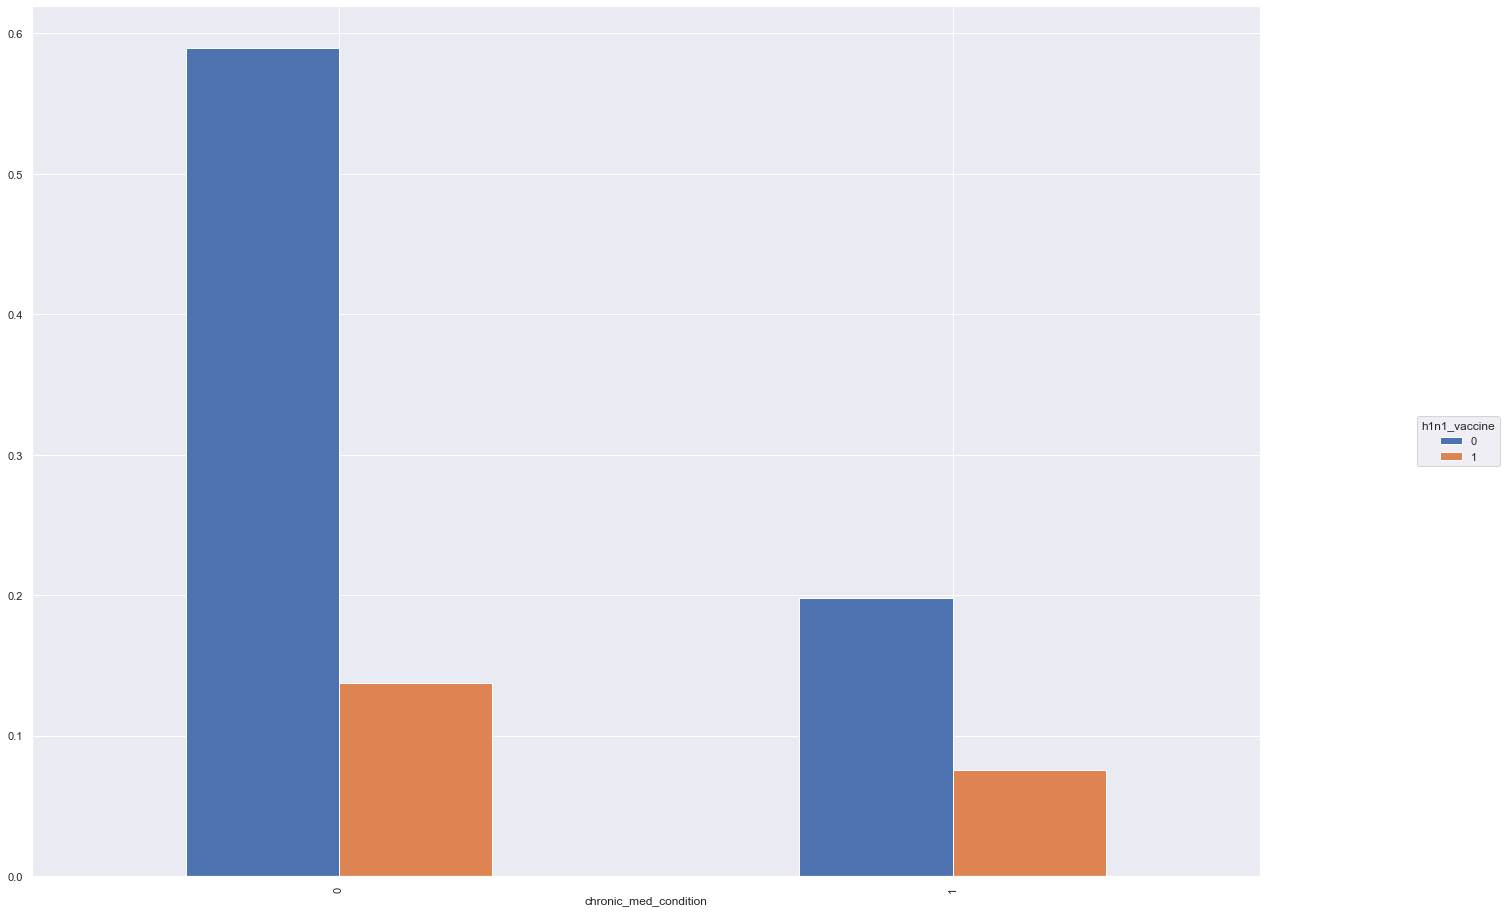

In [38]:
n_obs = df3.shape[0]

counts2 = (df3[['chronic_med_condition','h1n1_vaccine']]
              .groupby(['chronic_med_condition','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('h1n1_vaccine')
           )

ax = counts2.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='h1n1_vaccine')

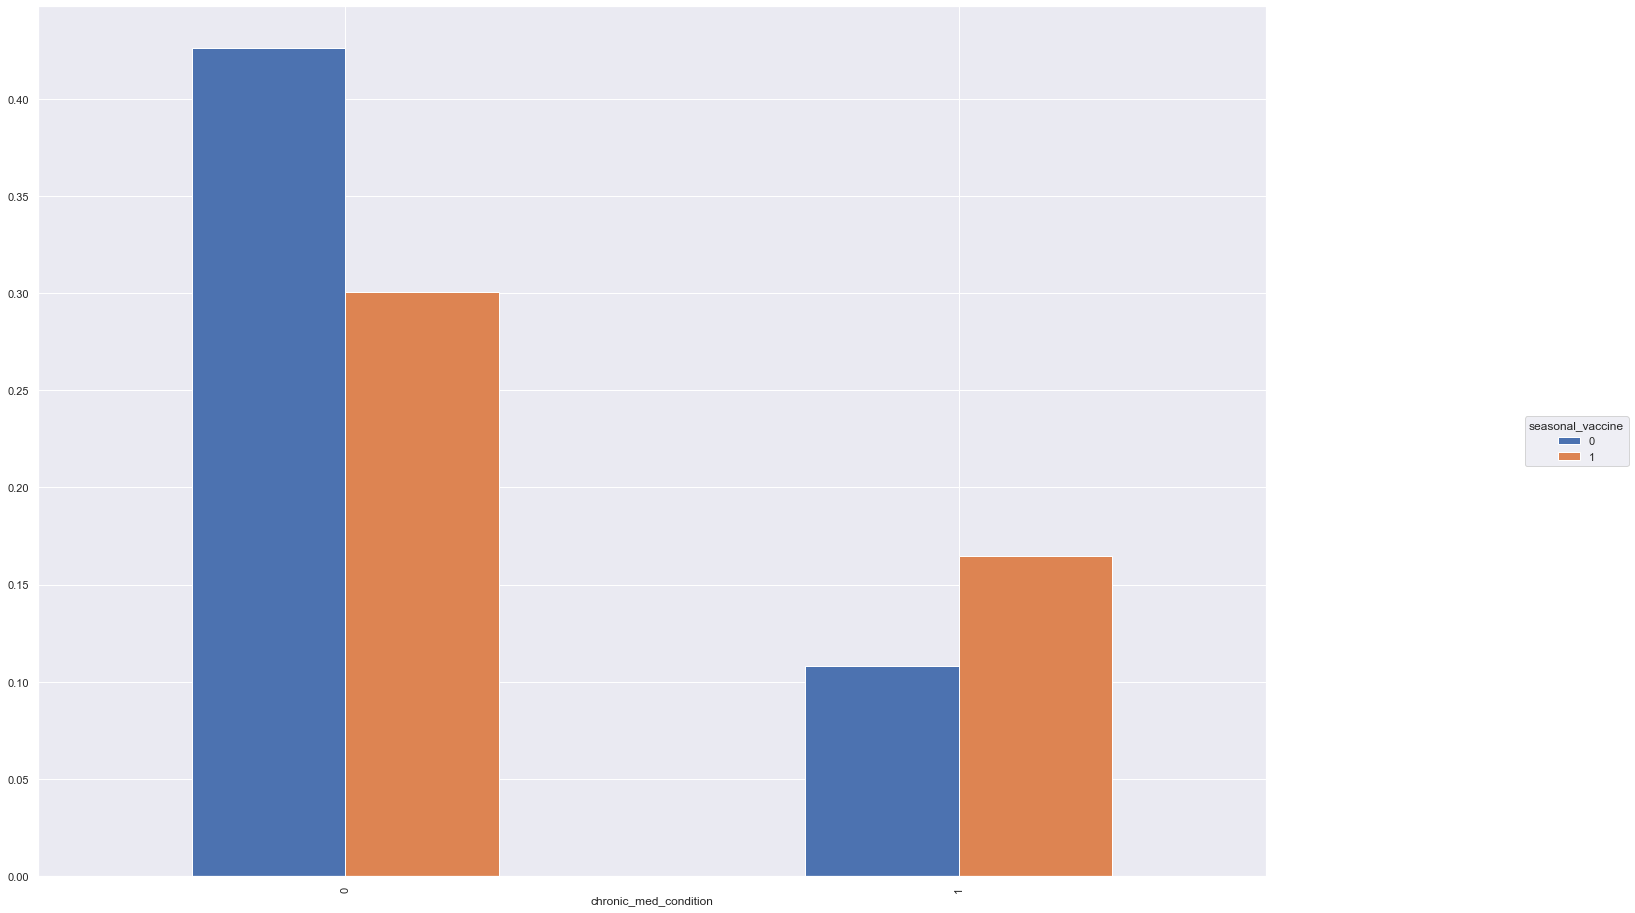

In [39]:
n_obs = df3.shape[0]

counts3 = (df3[['chronic_med_condition','seasonal_vaccine']]
              .groupby(['chronic_med_condition','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('seasonal_vaccine')
         )

ax = counts3.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='seasonal_vaccine')

In [40]:
counts2['0 em %'] = counts2[0]/(counts2[0] + counts2[1])*100
counts2['1 em %'] = counts2[1]/(counts2[0] + counts2[1])*100
counts2

h1n1_vaccine,0,1,0 em %,1 em %
chronic_med_condition,,,,
0,0.589696,0.137192,81.126050,18.873950
1,0.197851,0.075261,72.443104,27.556896


In [41]:
counts3['0 em %'] = counts3[0]/(counts3[0] + counts3[1])*100
counts3['1 em %'] = counts3[1]/(counts3[0] + counts3[1])*100
counts3

seasonal_vaccine,0,1,0 em %,1 em %
chronic_med_condition,,,,
0,0.426180,0.300708,58.630814,41.369186
1,0.108211,0.164901,39.621607,60.378393


## H3. Profissionais da saúde tendem a vacinar-se mais

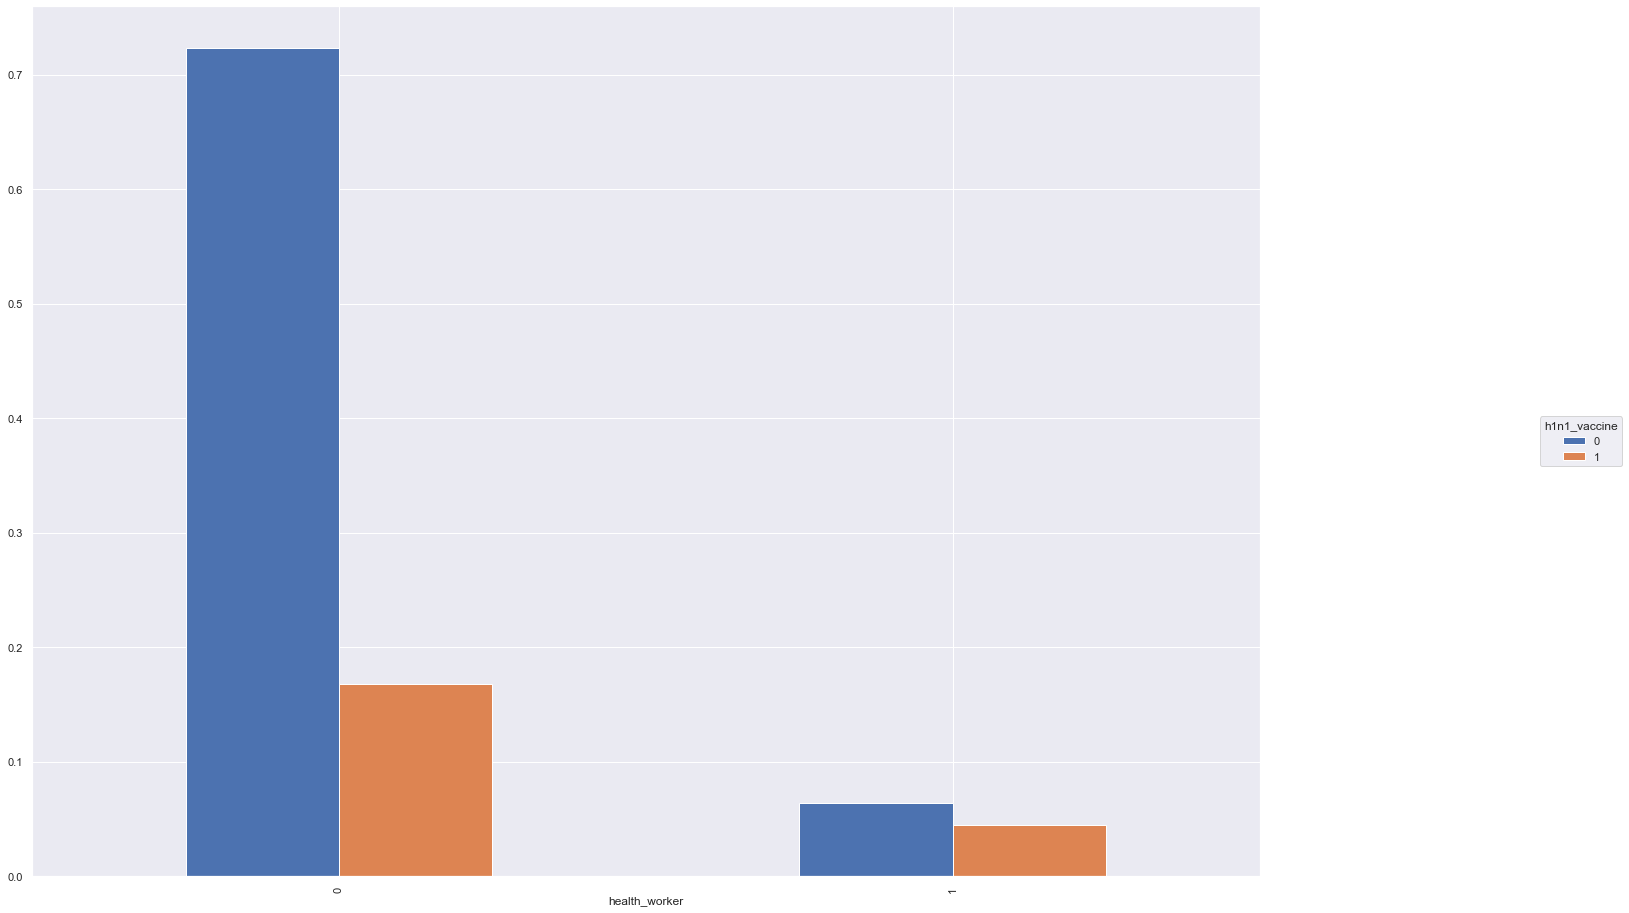

In [42]:
n_obs = df3.shape[0]

counts7 = (df3[['health_worker','h1n1_vaccine']]
              .groupby(['health_worker','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('h1n1_vaccine')
         )

ax = counts7.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='h1n1_vaccine')

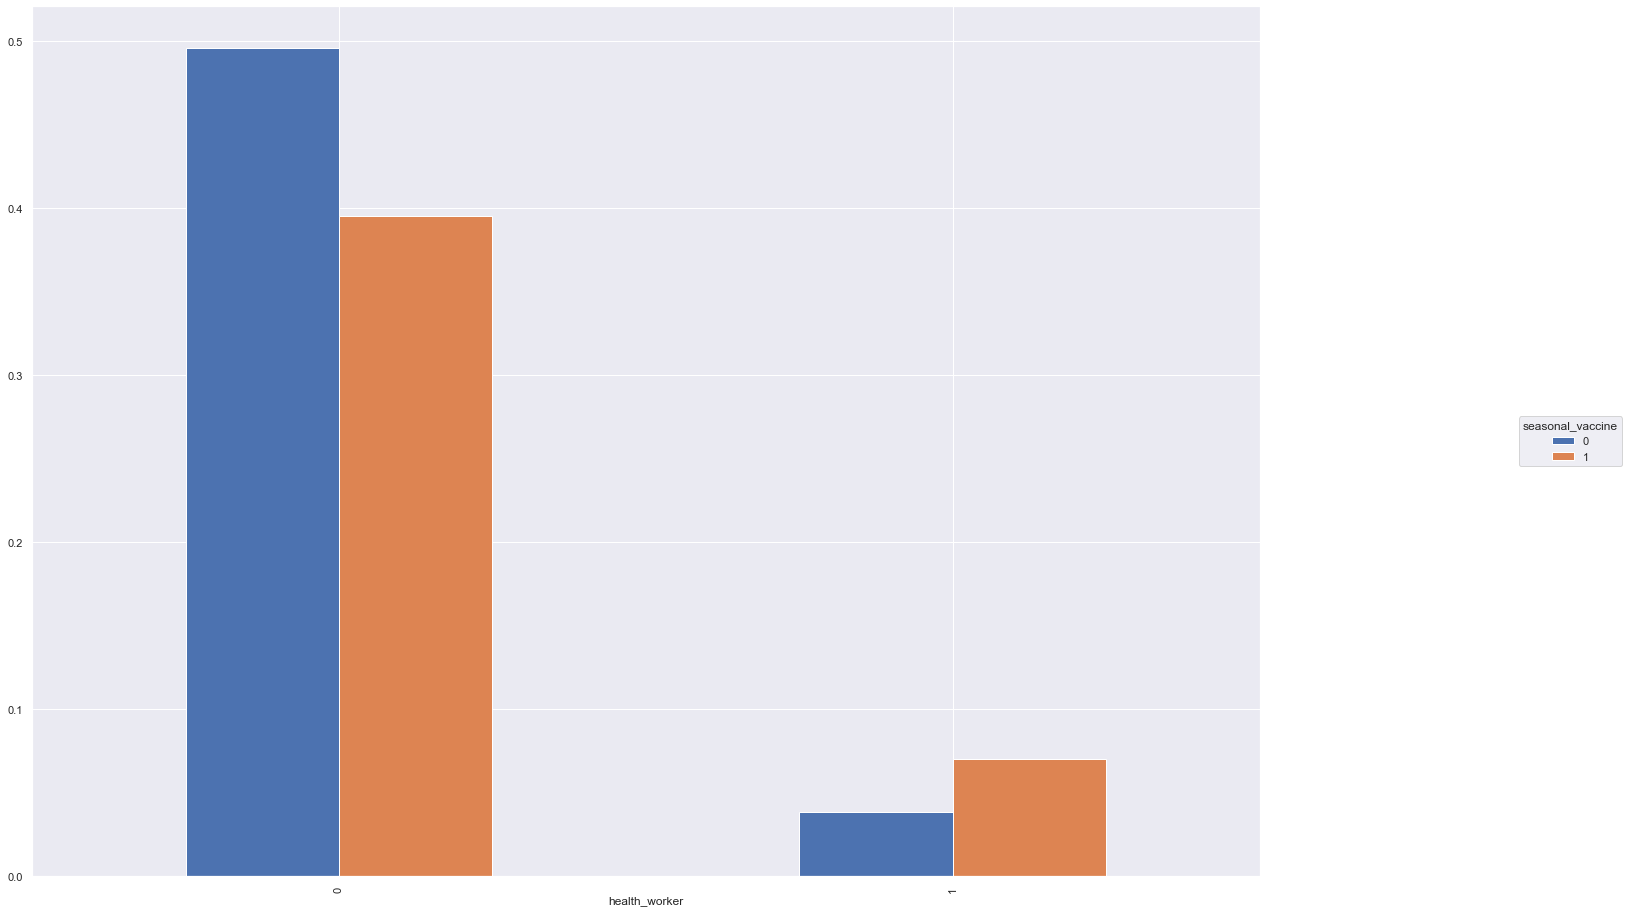

In [43]:
n_obs = df3.shape[0]

counts8 = (df3[['health_worker','seasonal_vaccine']]
              .groupby(['health_worker','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('seasonal_vaccine')
         )

ax = counts8.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='seasonal_vaccine')

In [44]:
counts7['0 em %'] = counts7[0]/(counts7[0] + counts7[1])*100
counts7['1 em %'] = counts7[1]/(counts7[0] + counts7[1])*100
counts7

h1n1_vaccine,0,1,0 em %,1 em %
health_worker,,,,
0,0.723443,0.168008,81.153394,18.846606
1,0.064103,0.044445,59.054846,40.945154


In [45]:
counts8['0 em %'] = counts8[0]/(counts8[0] + counts8[1])*100
counts8['1 em %'] = counts8[1]/(counts8[0] + counts8[1])*100
counts8

seasonal_vaccine,0,1,0 em %,1 em %
health_worker,,,,
0,0.496087,0.395365,55.649362,44.350638
1,0.038305,0.070244,35.288030,64.711970


## H4. Indivíduos tendem a vacinar-se mais contra gripes comuns 

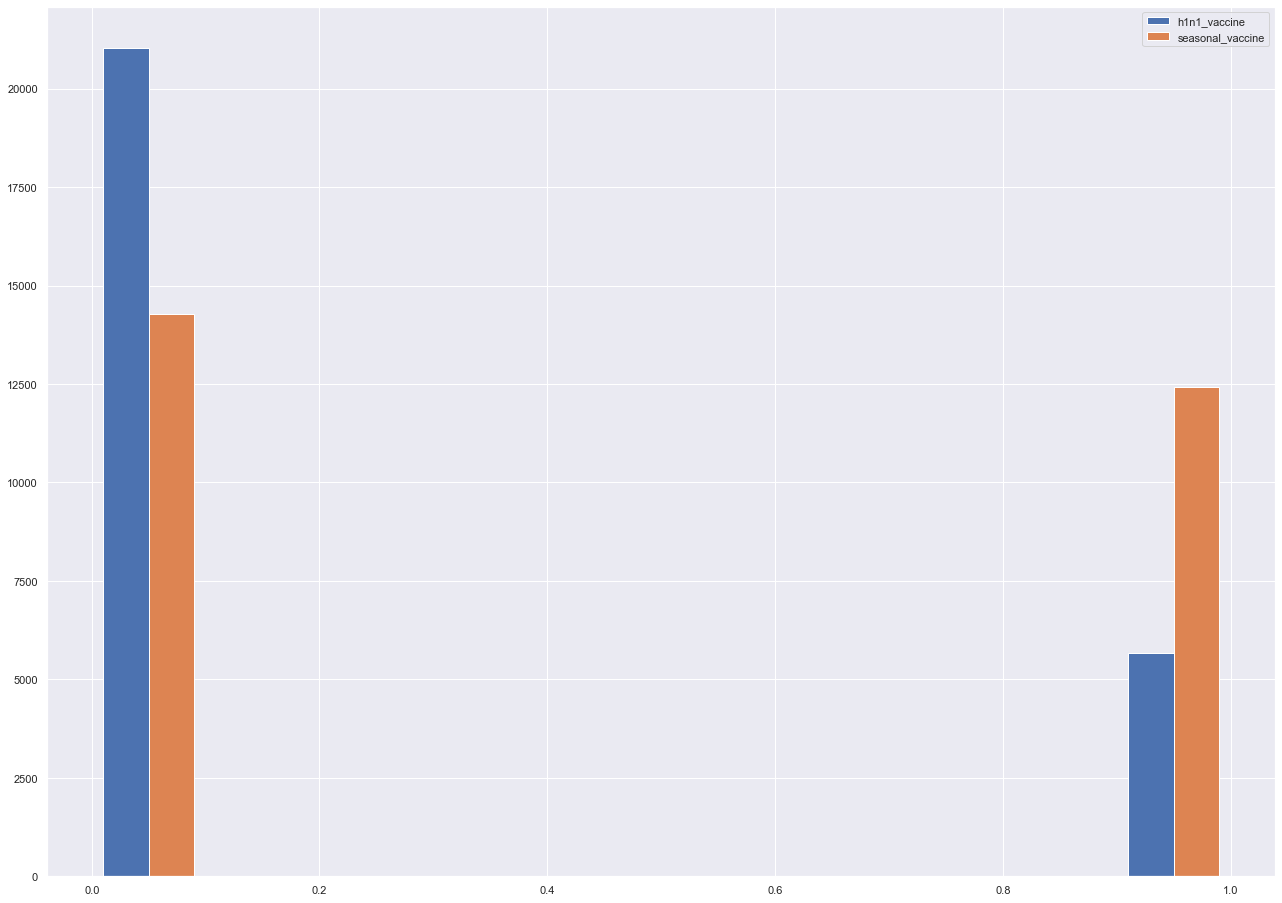

In [46]:
plt.hist([df3['h1n1_vaccine'], df3['seasonal_vaccine']], label=['h1n1_vaccine', 'seasonal_vaccine'])
plt.legend(loc='upper right')
plt.show()

In [47]:
counts4 = (df3[['h1n1_vaccine','seasonal_vaccine']]
              .groupby(['h1n1_vaccine','seasonal_vaccine'])
              .size()
              .div(n_obs))
counts4

h1n1_vaccine  seasonal_vaccine
0             0                   0.497810
              1                   0.289737
1             0                   0.036582
              1                   0.175871
dtype: float64

## H5. Mulheres tendem a vacinar-se mais

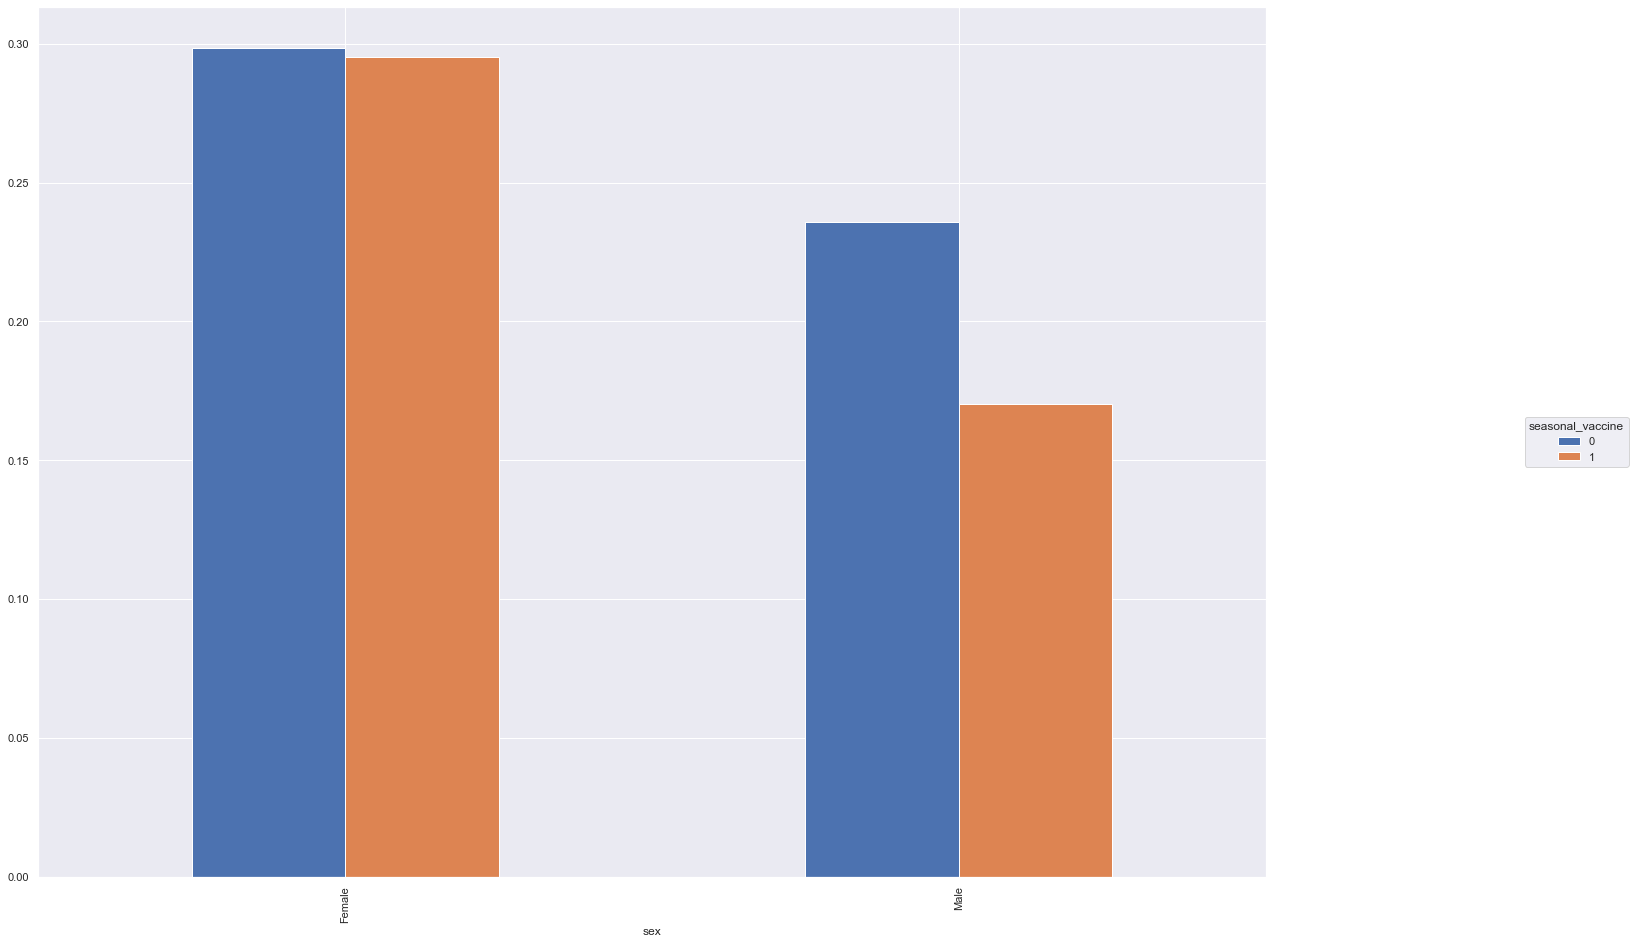

In [48]:
n_obs = df3.shape[0]

counts5 = (df3[['sex','seasonal_vaccine']]
              .groupby(['sex','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('seasonal_vaccine')
         )

ax = counts5.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='seasonal_vaccine')

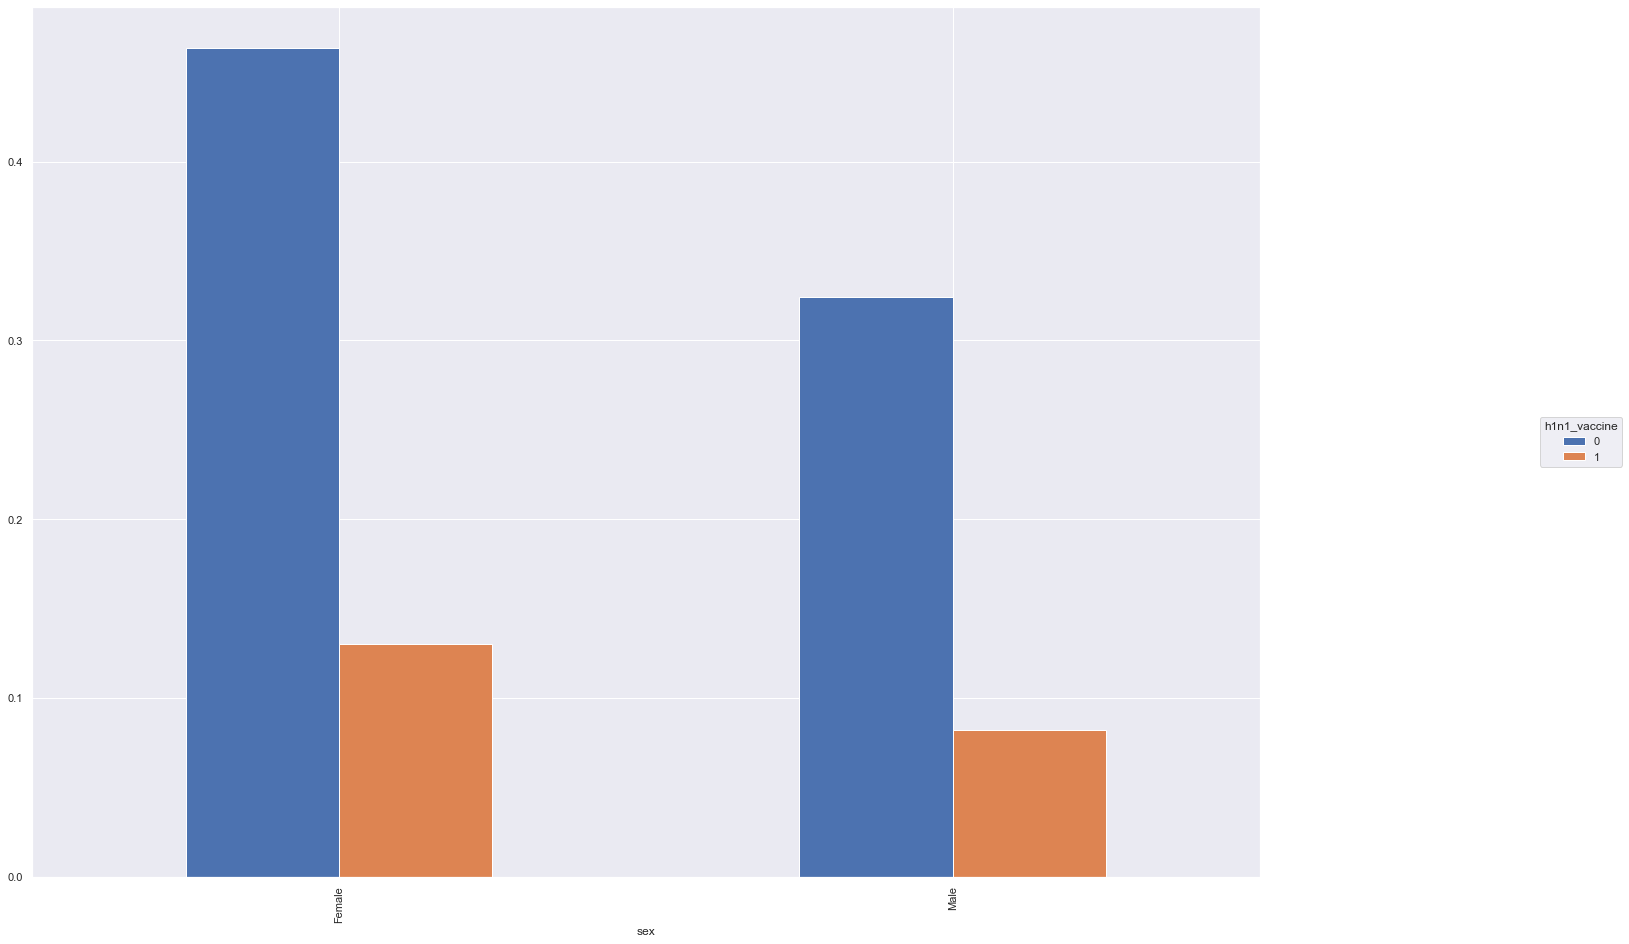

In [49]:
n_obs = df3.shape[0]

counts6 = (df3[['sex','h1n1_vaccine']]
              .groupby(['sex','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('h1n1_vaccine')
         )

ax = counts6.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='h1n1_vaccine')

In [50]:
counts5['0 em %'] = counts5[0]/(counts5[0] + counts5[1])*100
counts5['1 em %'] = counts5[1]/(counts5[0] + counts5[1])*100
counts5

seasonal_vaccine,0,1,0 em %,1 em %
sex,,,,
Female,0.298424,0.295353,50.258545,49.741455
Male,0.235968,0.170255,58.088303,41.911697


In [51]:
counts6['0 em %'] = counts6[0]/(counts6[0] + counts6[1])*100
counts6['1 em %'] = counts6[1]/(counts6[0] + counts6[1])*100
counts6

h1n1_vaccine,0,1,0 em %,1 em %
sex,,,,
Female,0.463474,0.130303,78.055240,21.944760
Male,0.324072,0.082151,79.776938,20.223062


## H6. Indivíduos com renda maior que 75,000 anuais tendem a vacinar-se mais

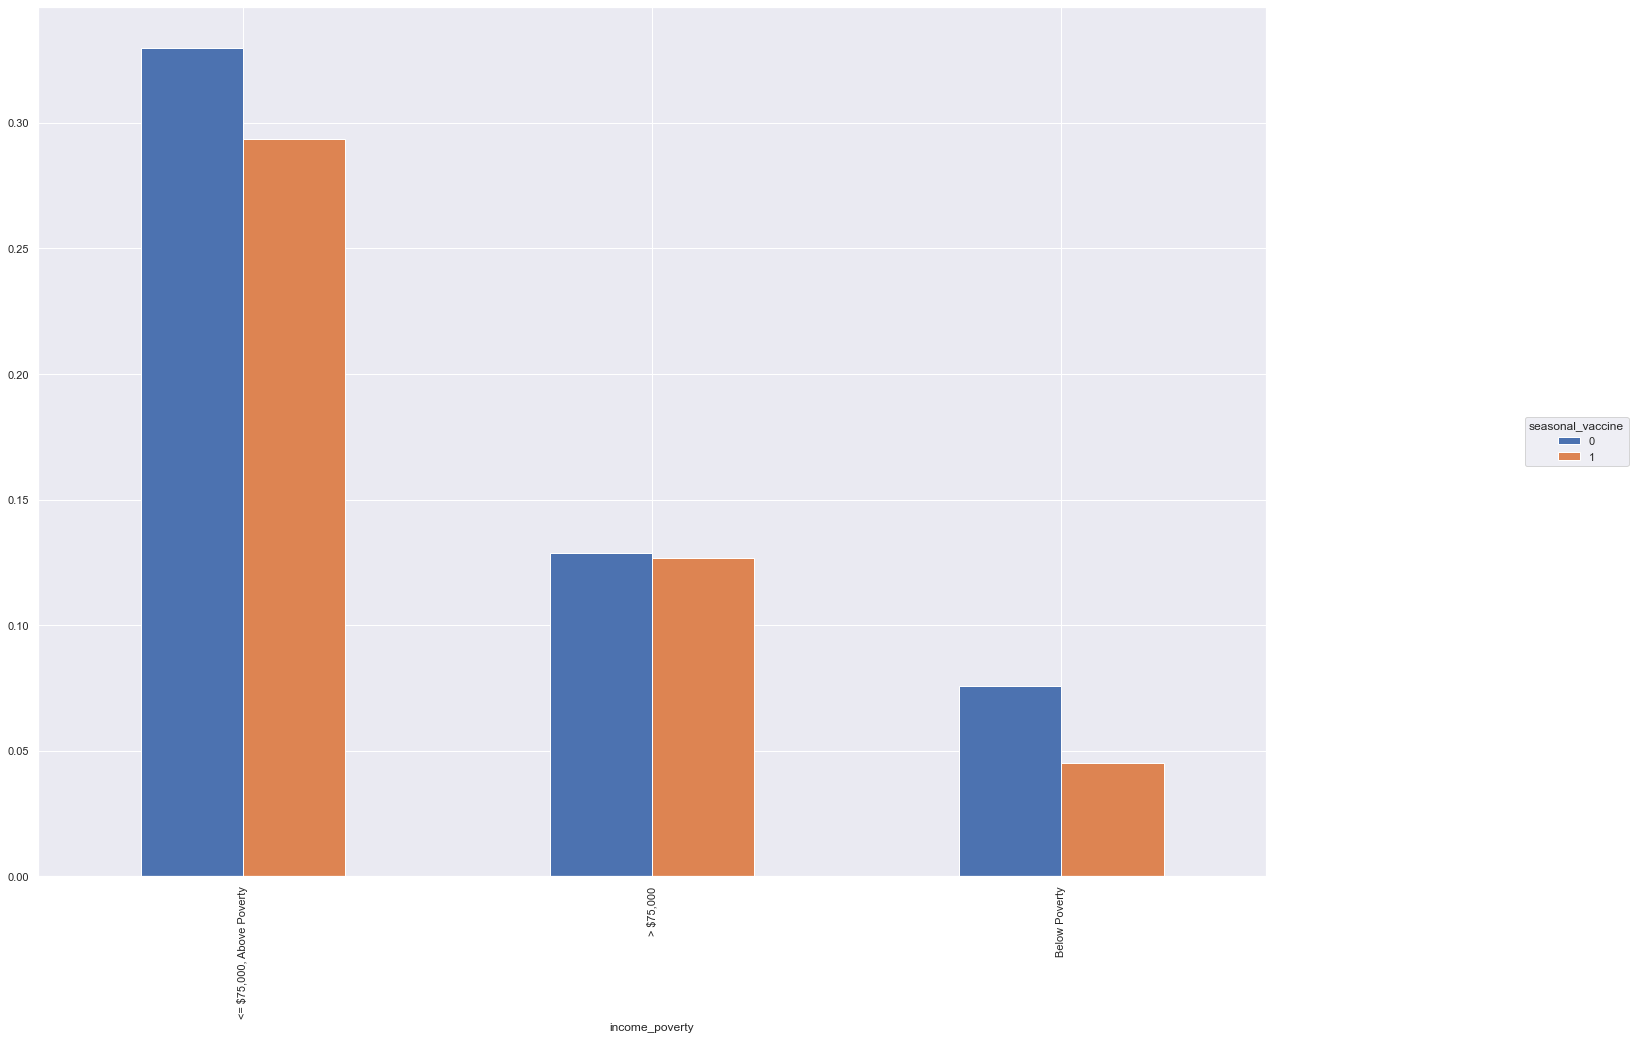

In [52]:
n_obs = df3.shape[0]

counts7 = (df3[['income_poverty','seasonal_vaccine']]
              .groupby(['income_poverty','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('seasonal_vaccine')
         )

ax = counts7.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='seasonal_vaccine')

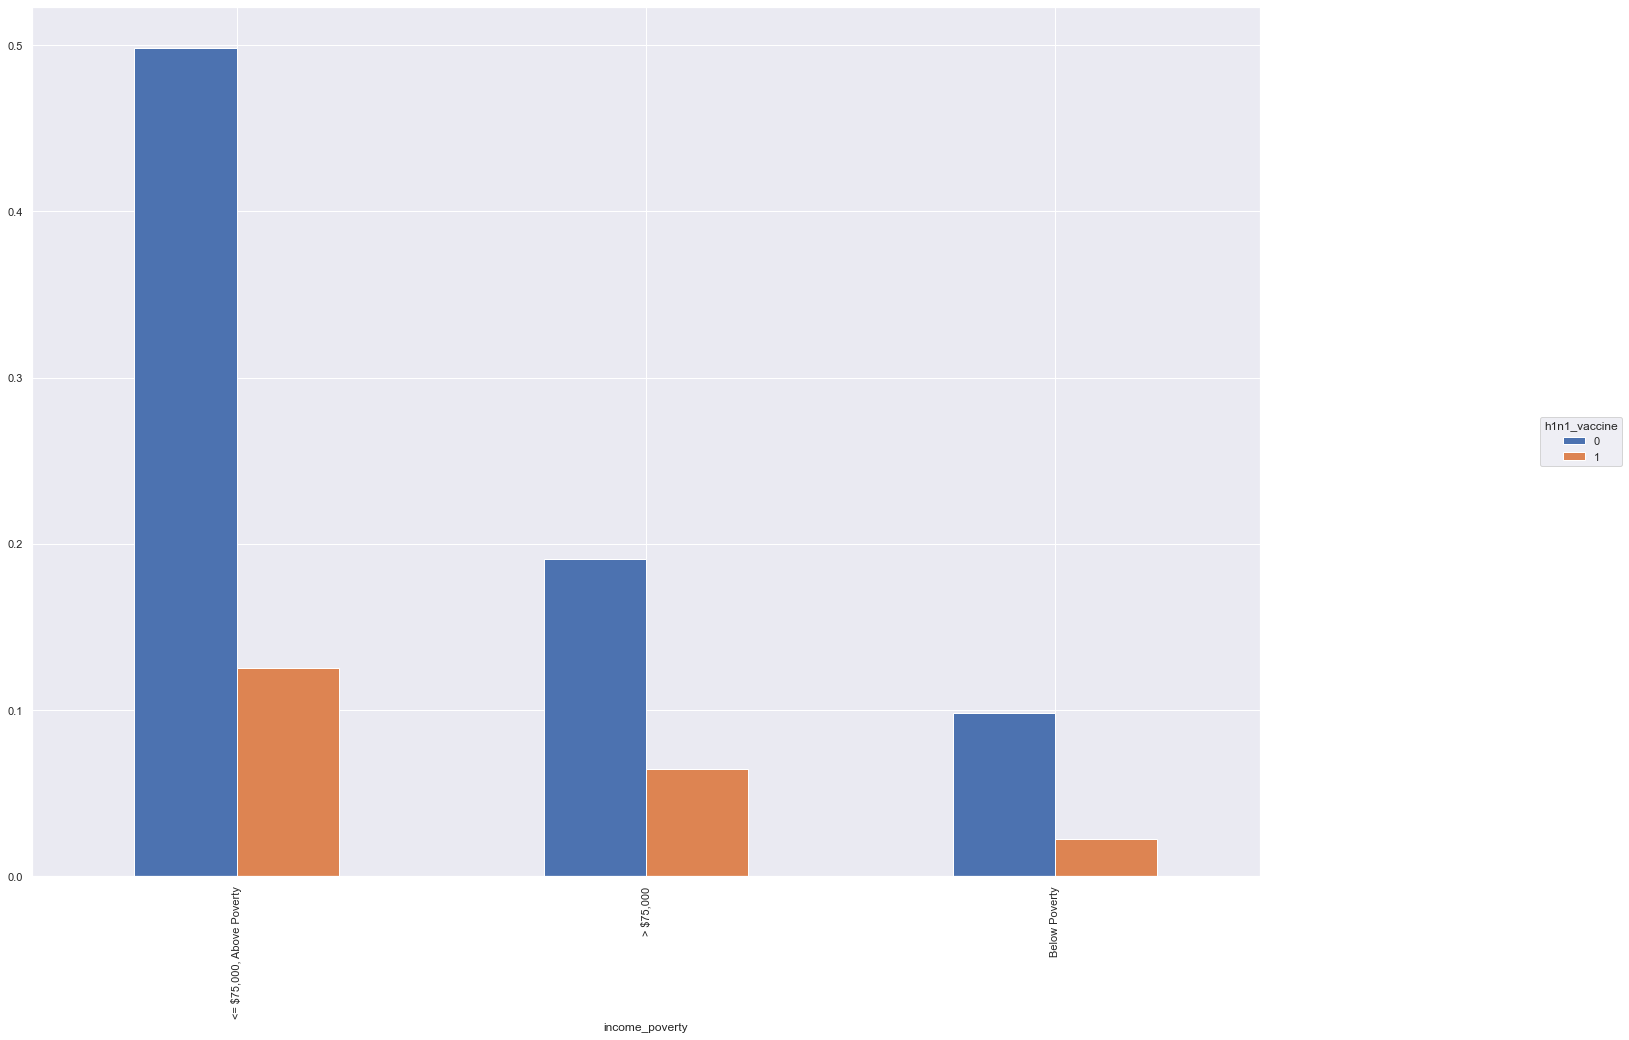

In [53]:
n_obs = df3.shape[0]

counts8 = (df3[['income_poverty','h1n1_vaccine']]
              .groupby(['income_poverty','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('h1n1_vaccine')
         )

ax = counts8.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='h1n1_vaccine')

In [54]:
counts7['0 em %'] = counts7[0]/(counts7[0] + counts7[1])*100
counts7['1 em %'] = counts7[1]/(counts7[0] + counts7[1])*100
counts7

seasonal_vaccine,0,1,0 em %,1 em %
income_poverty,,,,
"<= $75,000, Above Poverty",0.329801,0.293519,52.910434,47.089566
"> $75,000",0.128880,0.126821,50.402694,49.597306
Below Poverty,0.075710,0.045269,62.581244,37.418756


In [55]:
counts8['0 em %'] = counts8[0]/(counts8[0] + counts8[1])*100
counts8['1 em %'] = counts8[1]/(counts8[0] + counts8[1])*100
counts8

h1n1_vaccine,0,1,0 em %,1 em %
income_poverty,,,,
"<= $75,000, Above Poverty",0.498147,0.125173,79.918304,20.081696
"> $75,000",0.191111,0.064590,74.740079,25.259921
Below Poverty,0.098289,0.022691,81.244197,18.755803


## H7. Indivíduos que residem na região metropolitana tendem a vacinar-se mais

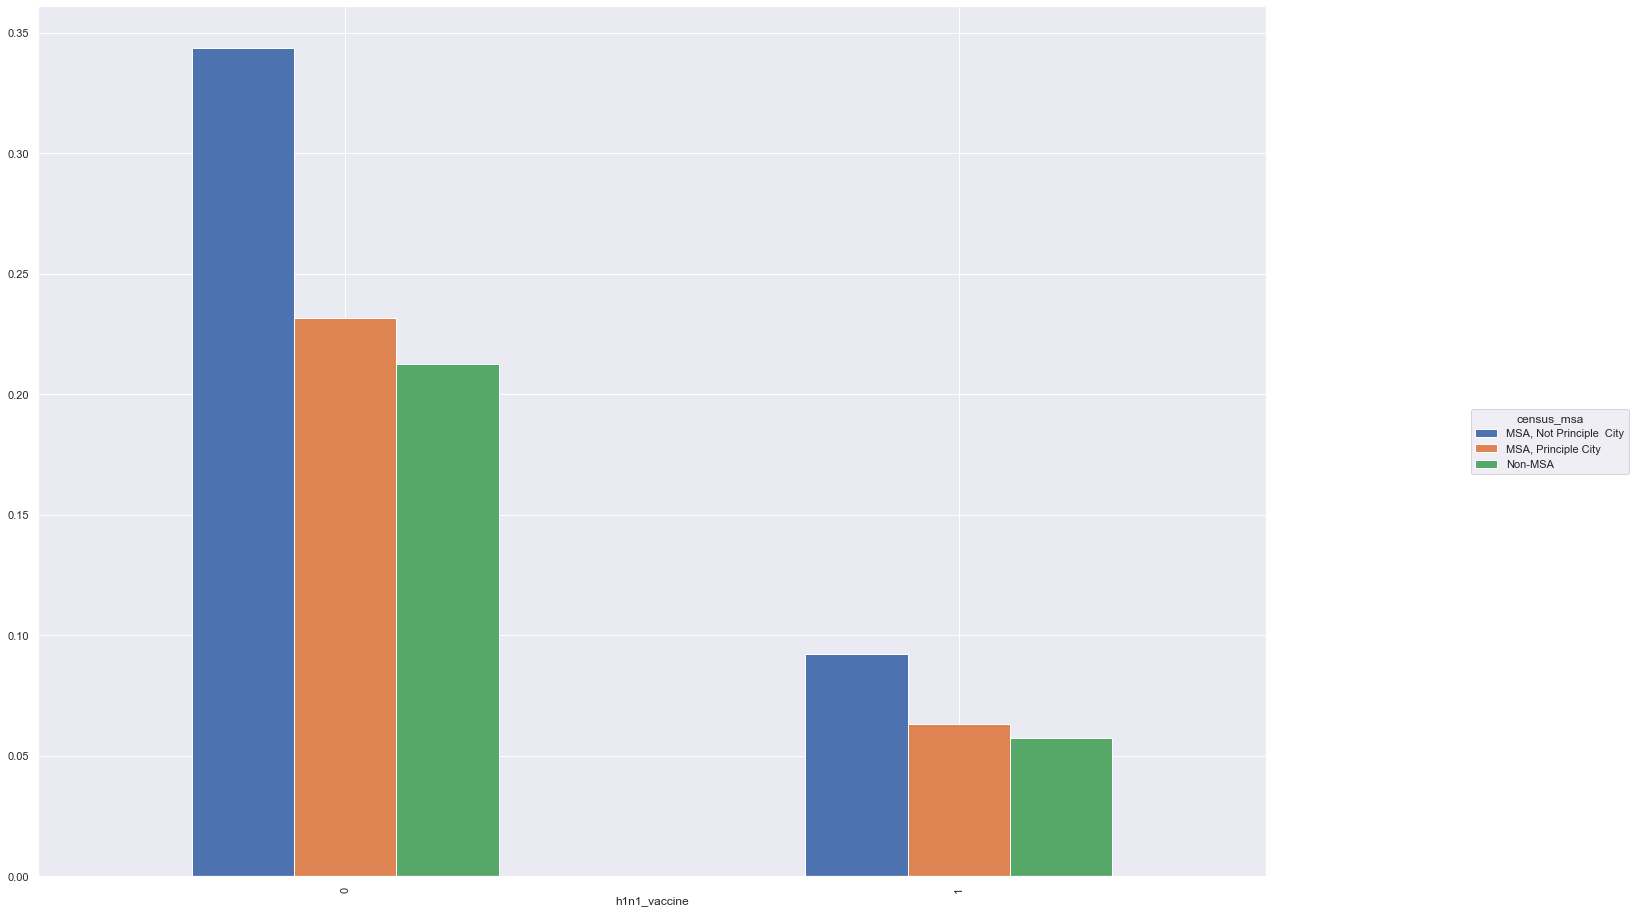

In [56]:
n_obs = df3.shape[0]

counts9 = (df3[['census_msa','h1n1_vaccine']]
              .groupby(['census_msa','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('census_msa')
         )

ax = counts9.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='census_msa')

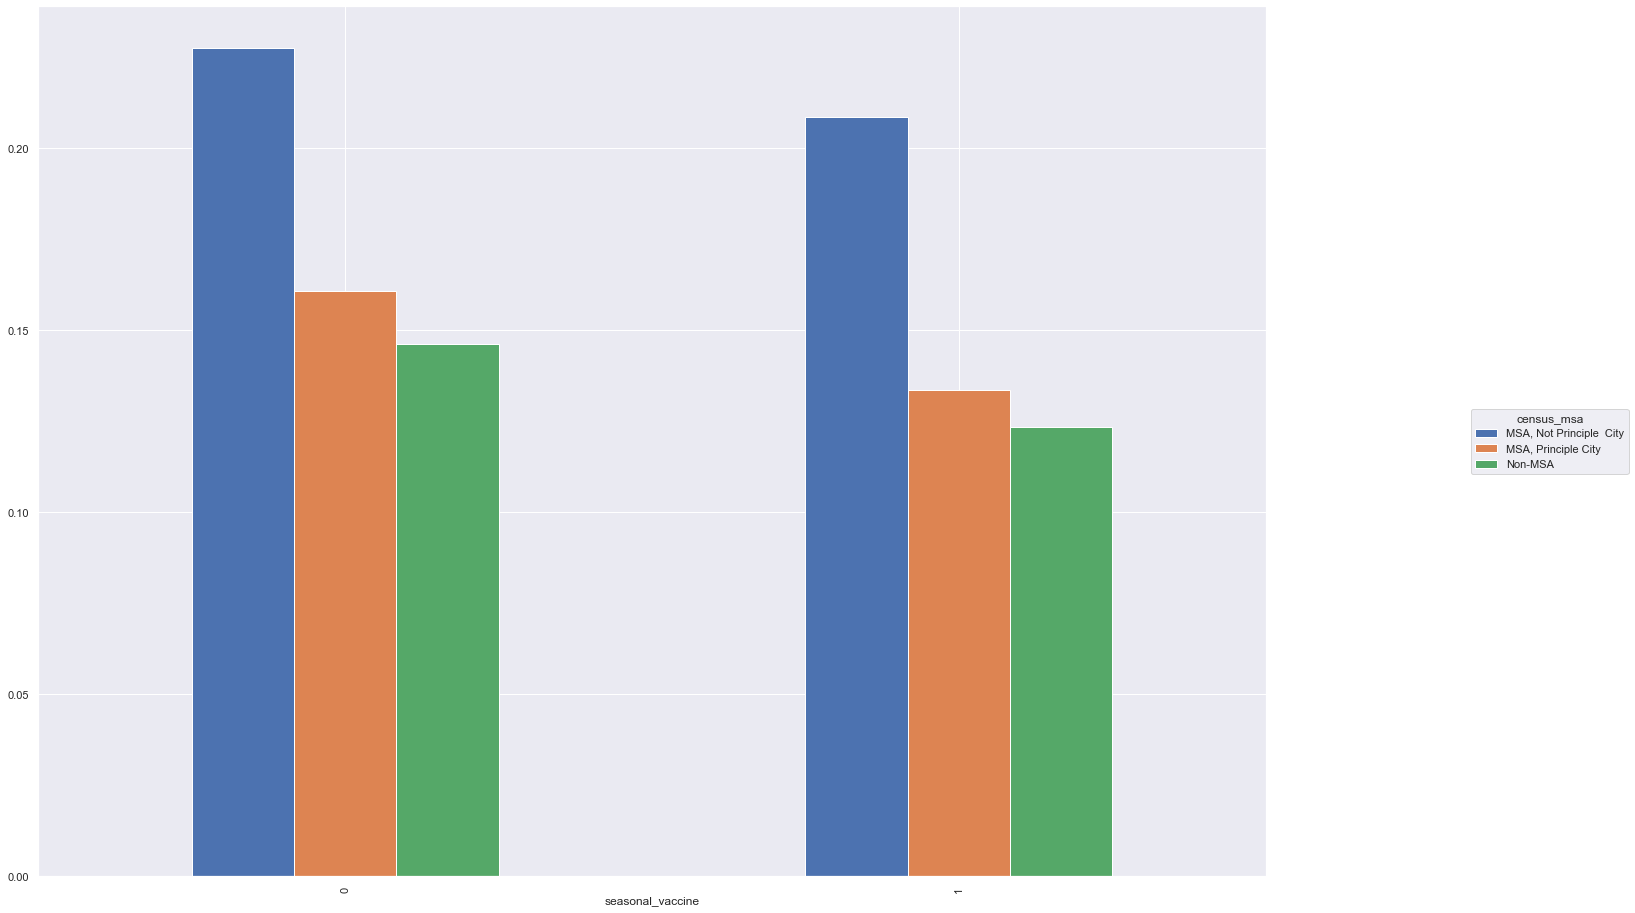

In [57]:
n_obs = df3.shape[0]

counts10 = (df3[['census_msa','seasonal_vaccine']]
              .groupby(['census_msa','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('census_msa')
         )

ax = counts10.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='census_msa')

In [58]:
counts9

census_msa,"MSA, Not Principle City","MSA, Principle City",Non-MSA
h1n1_vaccine,,,
0,0.343655,0.231512,0.212379
1,0.092373,0.062942,0.057139


In [59]:
counts10

census_msa,"MSA, Not Principle City","MSA, Principle City",Non-MSA
seasonal_vaccine,,,
0,0.227506,0.160857,0.146029
1,0.208522,0.133598,0.123488


## H8. Indivíduos que residem com crianças em casa tendem a vacinar-se mais

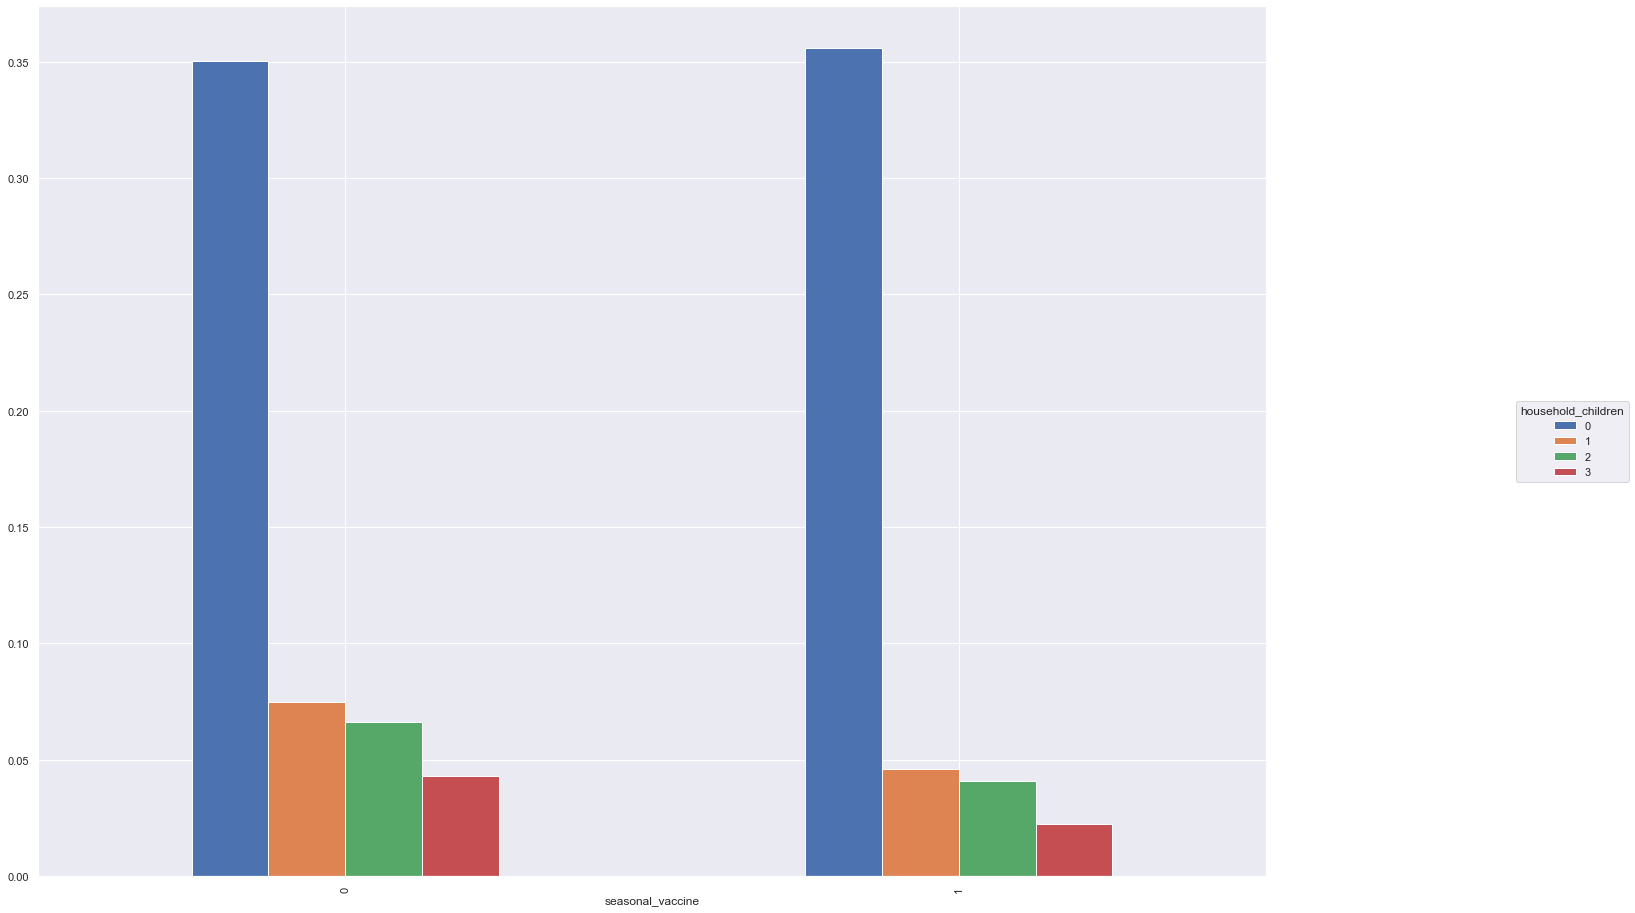

In [60]:
n_obs = df3.shape[0]

counts11 = (df3[['household_children','seasonal_vaccine']]
              .groupby(['household_children','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('household_children')
         )

ax = counts11.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='household_children')

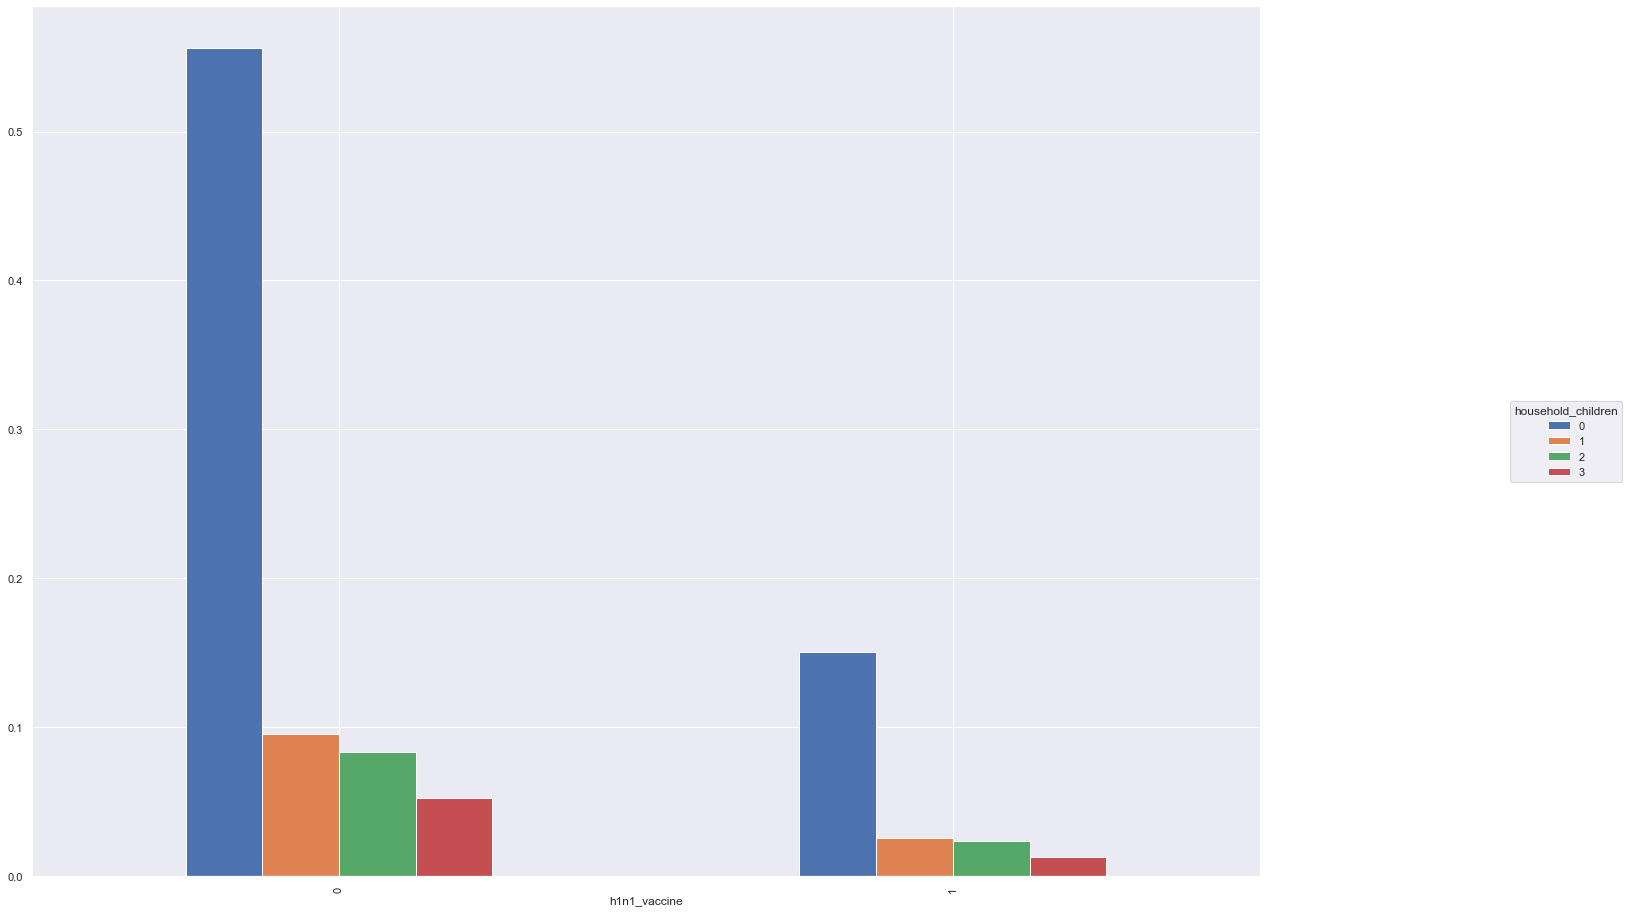

In [61]:
n_obs = df3.shape[0]

counts12 = (df3[['household_children','h1n1_vaccine']]
              .groupby(['household_children','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('household_children')
         )

ax = counts12.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='household_children')

In [62]:
counts11

household_children,0,1,2,3
seasonal_vaccine,,,,
0,0.350507,0.074662,0.066237,0.042985
1,0.355974,0.046205,0.041000,0.022429


In [63]:
counts12

household_children,0,1,2,3
h1n1_vaccine,,,,
0,0.556221,0.095293,0.083686,0.052346
1,0.150260,0.025574,0.023552,0.013068


## H9. Indivíduos que residem com uma quantidade maior de adultos em casa tendem a vacinar-se menos

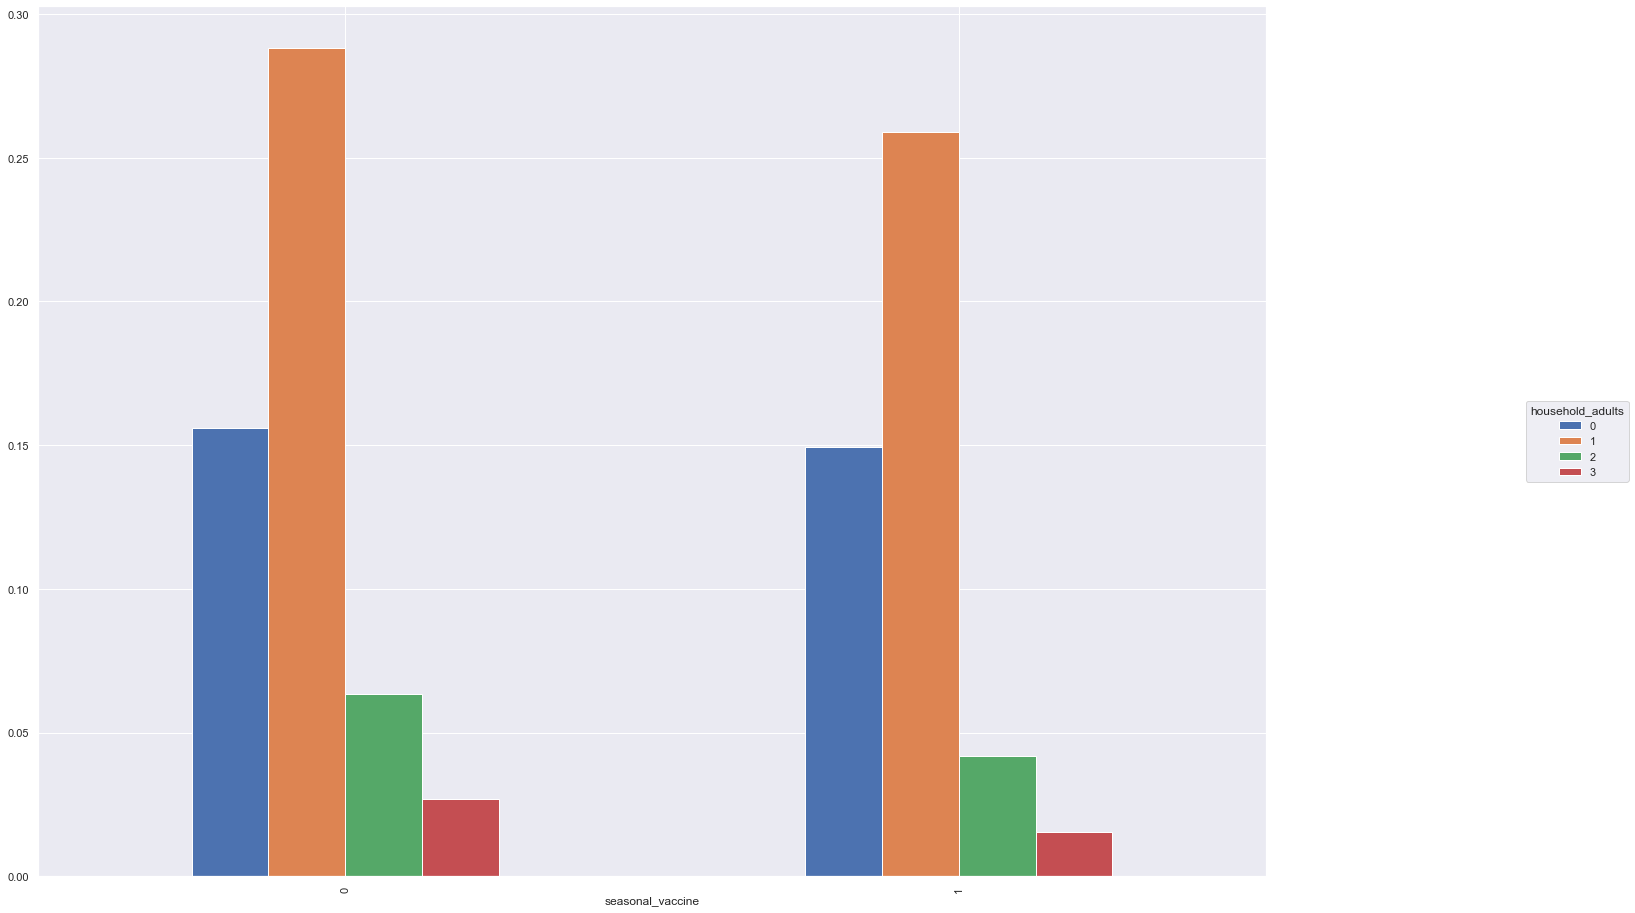

In [64]:
n_obs = df3.shape[0]

counts13 = (df3[['household_adults','seasonal_vaccine']]
              .groupby(['household_adults','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('household_adults')
         )

ax = counts13.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='household_adults')

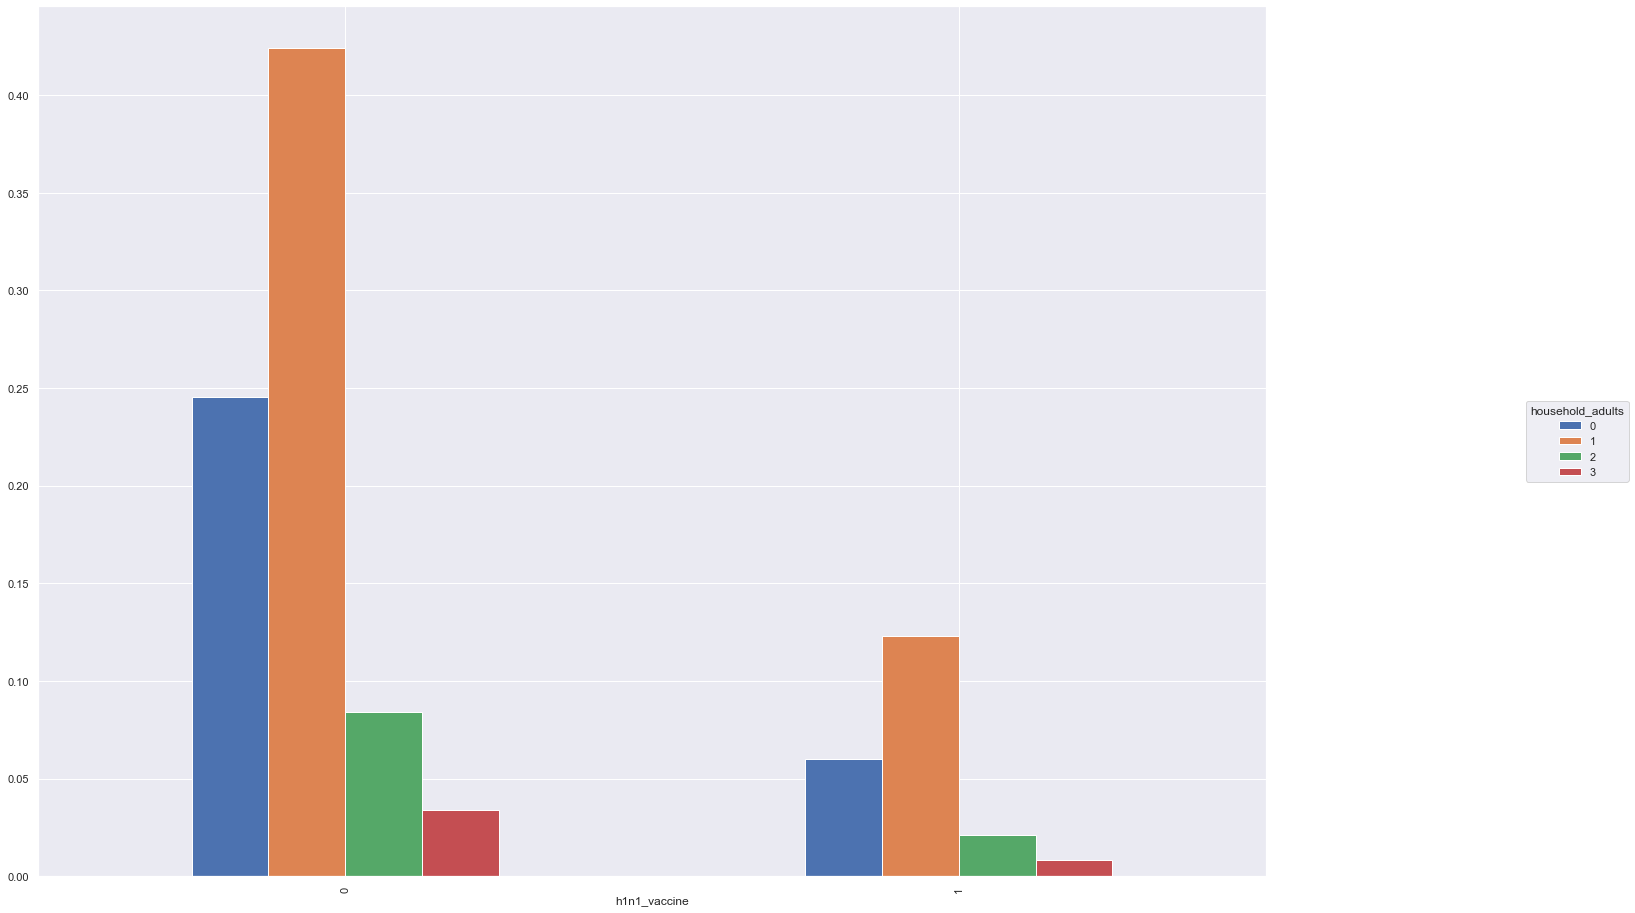

In [65]:
n_obs = df3.shape[0]

counts14 = (df3[['household_adults','h1n1_vaccine']]
              .groupby(['household_adults','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('household_adults')
         )

ax = counts14.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='household_adults')

In [66]:
counts13

household_adults,0,1,2,3
seasonal_vaccine,,,,
0,0.155952,0.288276,0.063317,0.026847
1,0.149511,0.259146,0.041674,0.015277


In [67]:
counts14

household_adults,0,1,2,3
h1n1_vaccine,,,,
0,0.245628,0.424233,0.083873,0.033811
1,0.059835,0.123189,0.021118,0.008312


## H10. Indivíduos empregados tendem a vacinar-se mais

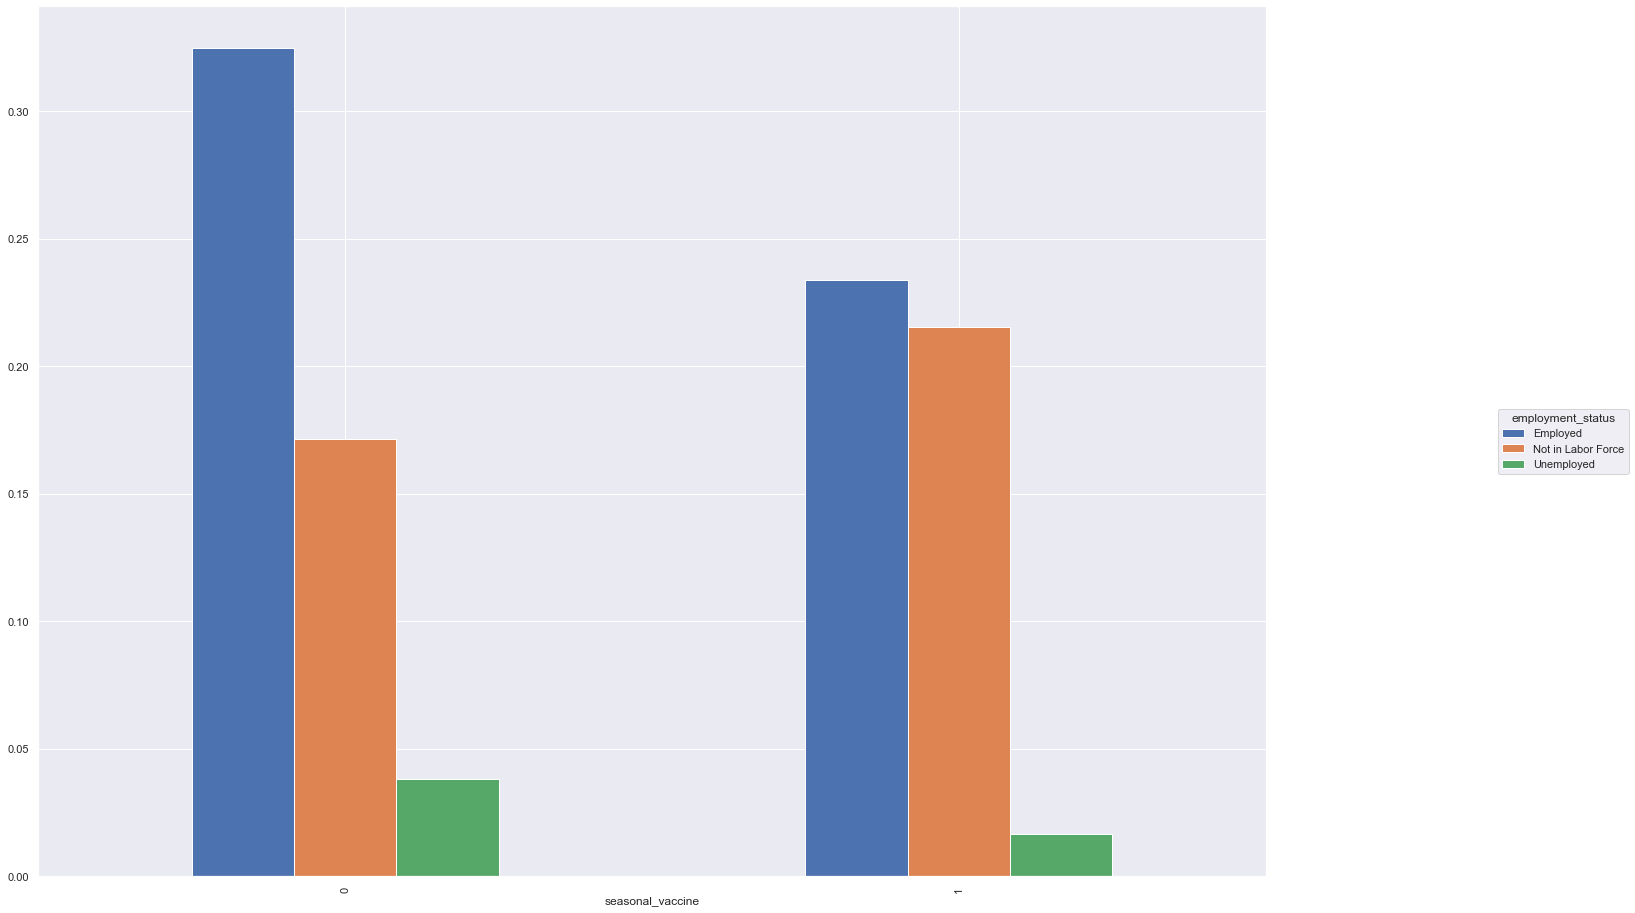

In [68]:
n_obs = df3.shape[0]

counts13 = (df3[['employment_status','seasonal_vaccine']]
              .groupby(['employment_status','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('employment_status')
         )

ax = counts13.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='employment_status')

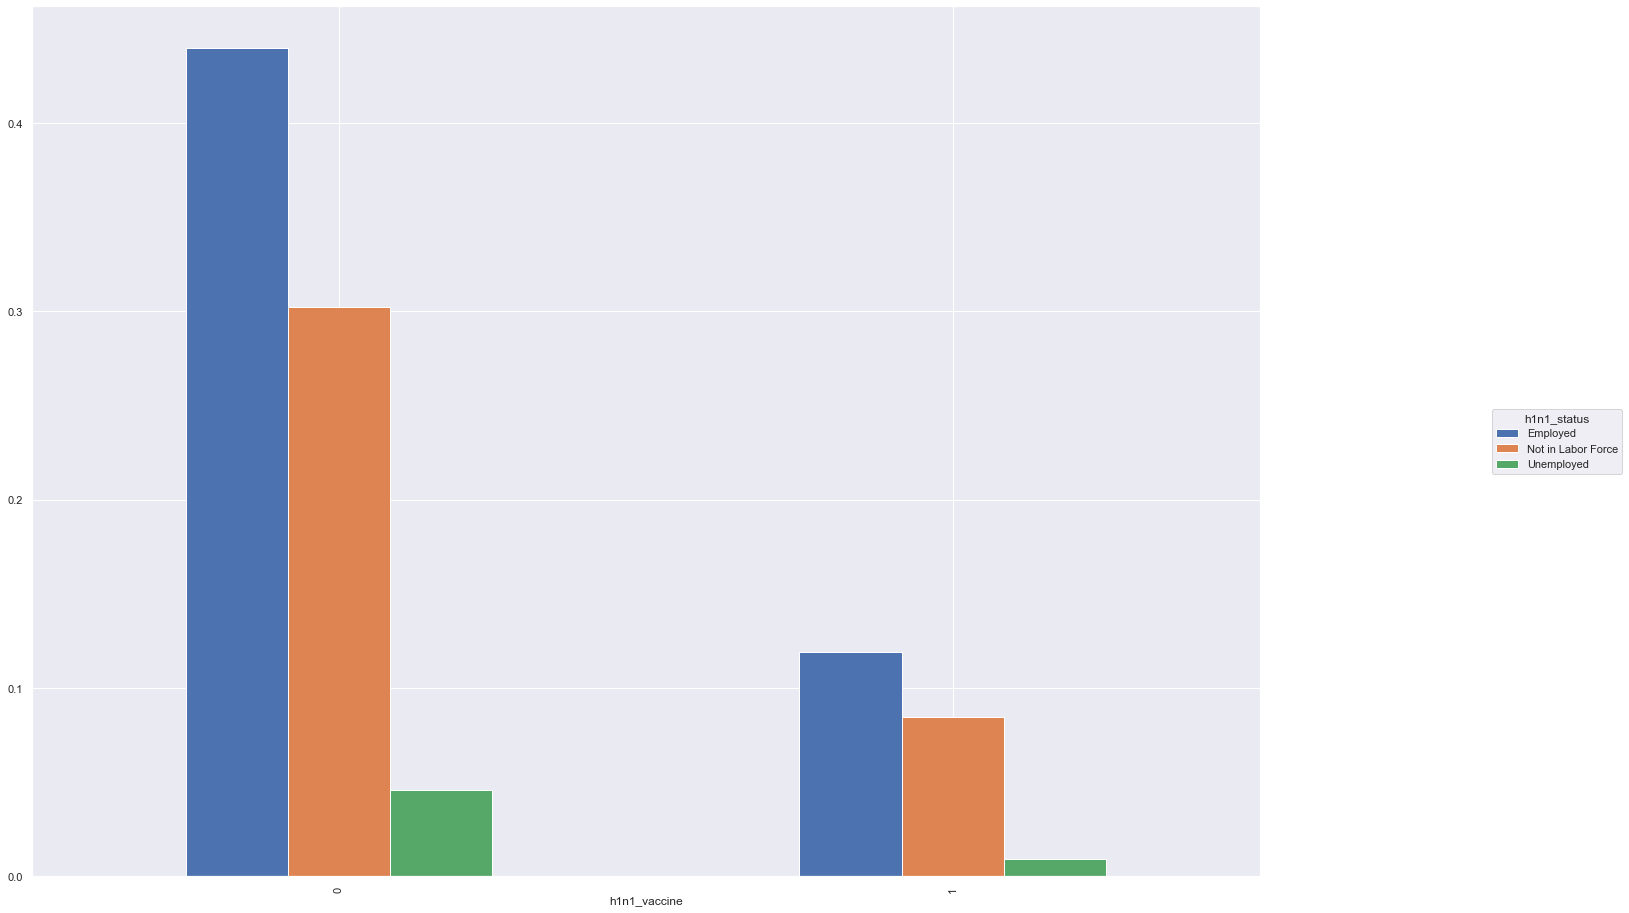

In [69]:
n_obs = df3.shape[0]

counts14 = (df3[['employment_status','h1n1_vaccine']]
              .groupby(['employment_status','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('employment_status')
         )

ax = counts14.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='h1n1_status')

In [70]:
counts13

employment_status,Employed,Not in Labor Force,Unemployed
seasonal_vaccine,,,
0,0.324859,0.171566,0.037968
1,0.233871,0.215299,0.016438


In [71]:
counts14

employment_status,Employed,Not in Labor Force,Unemployed
h1n1_vaccine,,,
0,0.439847,0.302168,0.045531
1,0.118883,0.084697,0.008874


##  H11. Indivíduos tendem a vacinar-se mais quando recomendadas pelos médicos

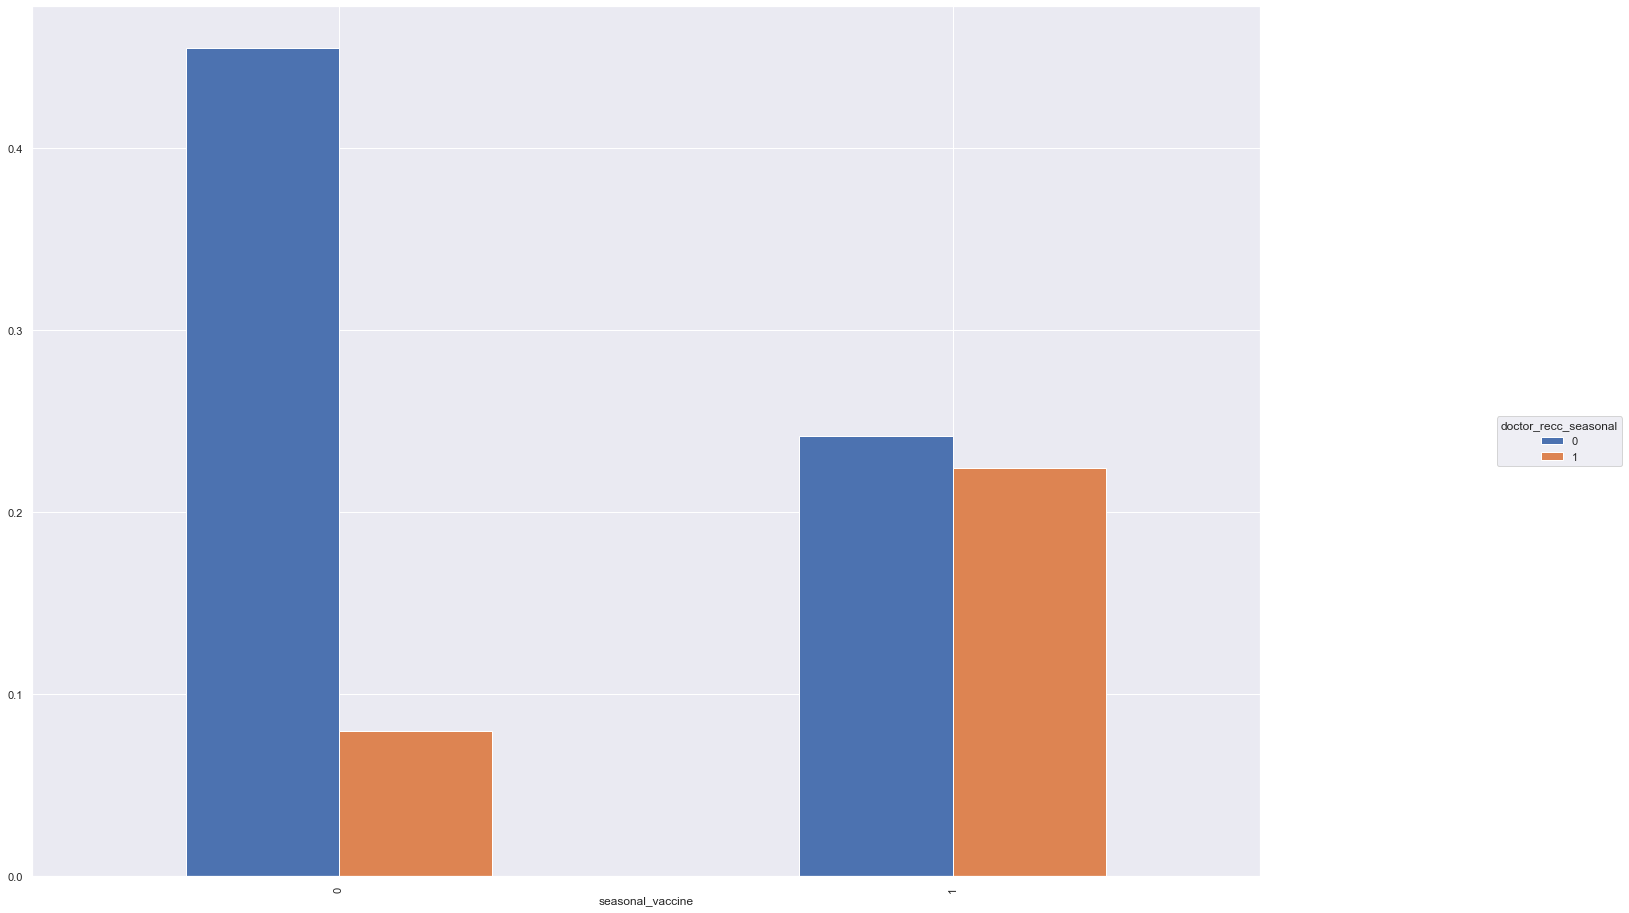

In [72]:
n_obs = df3.shape[0]

counts15 = (df3[['doctor_recc_seasonal','seasonal_vaccine']]
              .groupby(['doctor_recc_seasonal','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('doctor_recc_seasonal')
         )

ax = counts15.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='doctor_recc_seasonal')

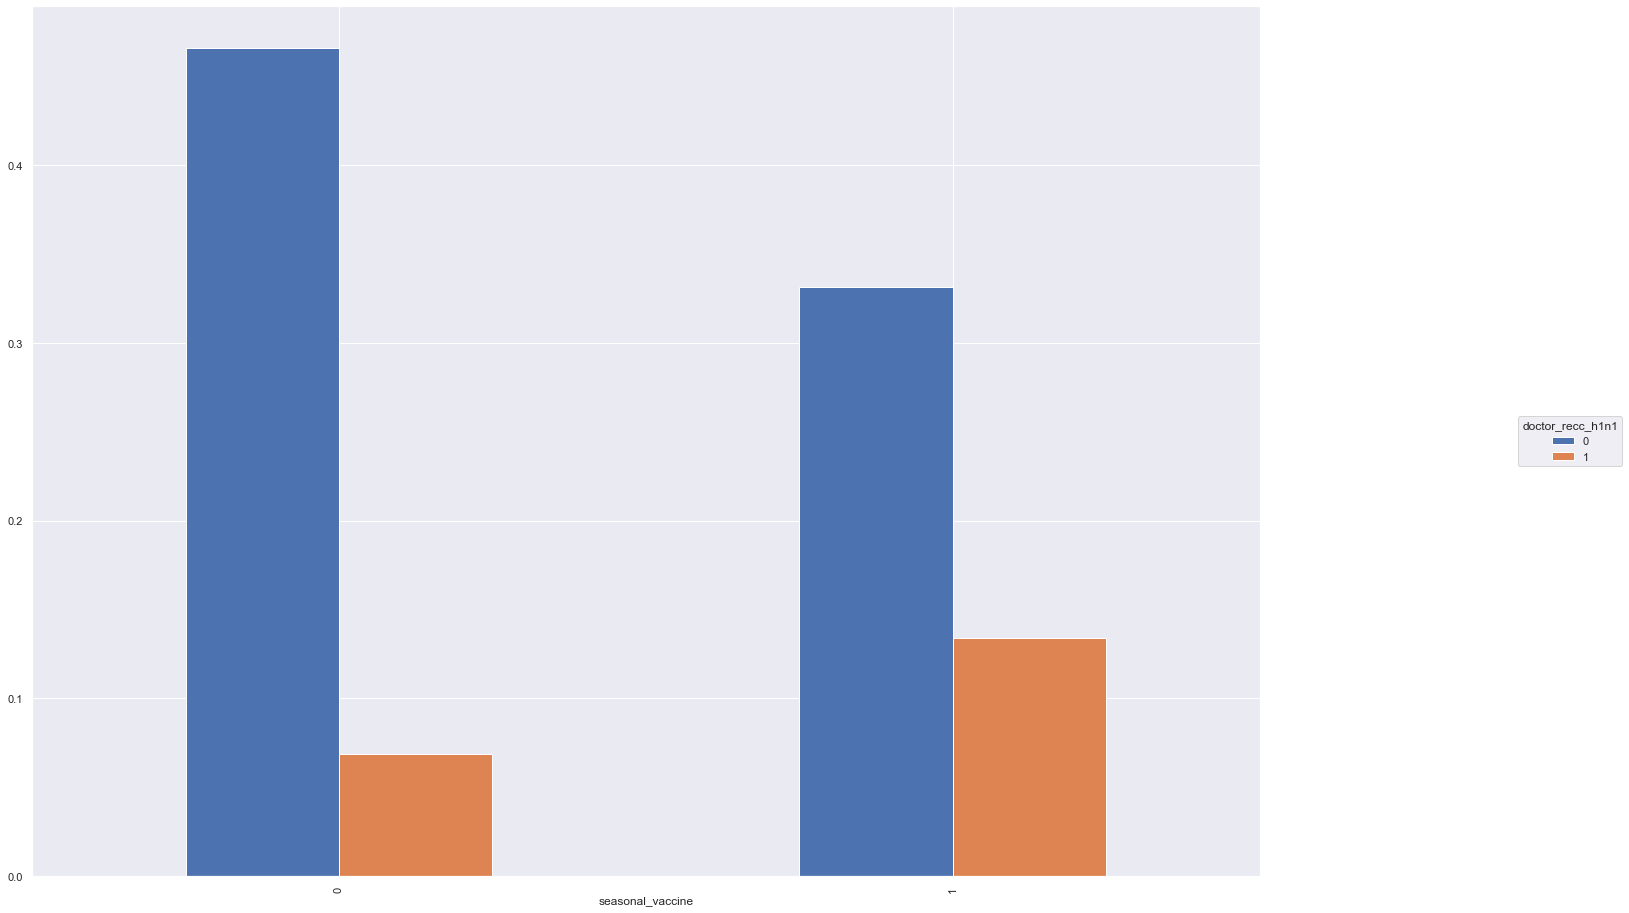

In [73]:
n_obs = df3.shape[0]

counts16 = (df3[['doctor_recc_h1n1','seasonal_vaccine']]
              .groupby(['doctor_recc_h1n1','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('doctor_recc_h1n1')
         )

ax = counts16.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='doctor_recc_h1n1')

In [74]:
counts15

doctor_recc_seasonal,0,1
seasonal_vaccine,,
0,0.454899,0.079492
1,0.241510,0.224099


In [75]:
counts16

doctor_recc_h1n1,0,1
seasonal_vaccine,,
0,0.465945,0.068446
1,0.331524,0.134085


## H12. Indivíduos com maior acesso à educação tendem a vacinar-se mais

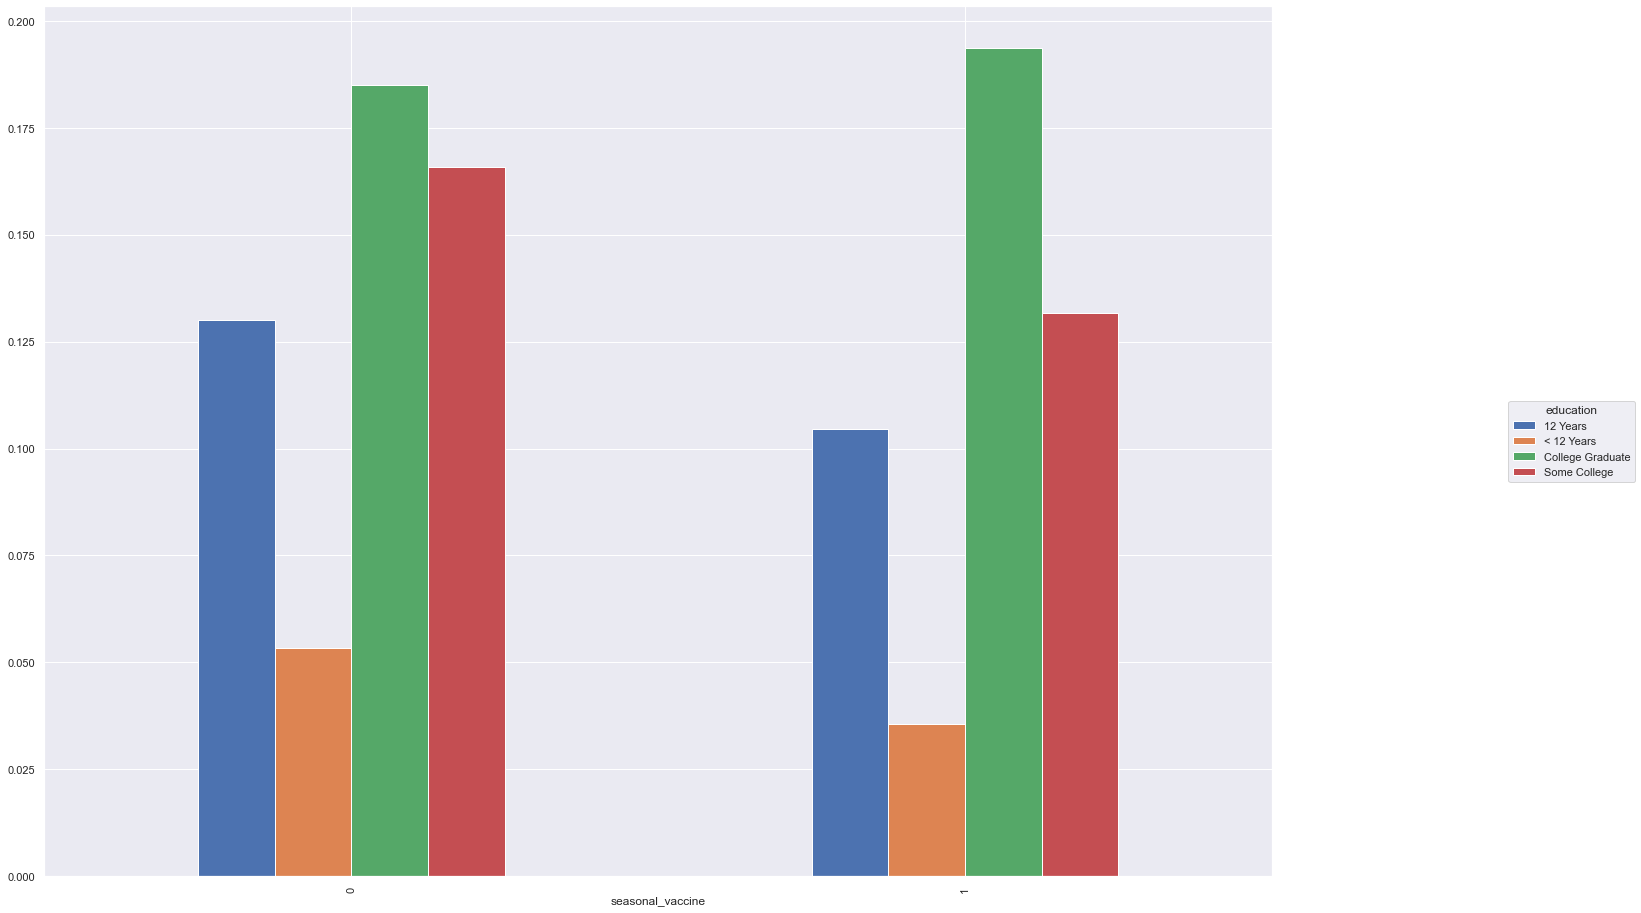

In [76]:
n_obs = df3.shape[0]

counts17 = (df3[['education','seasonal_vaccine']]
              .groupby(['education','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('education')
         )

ax = counts17.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='education')

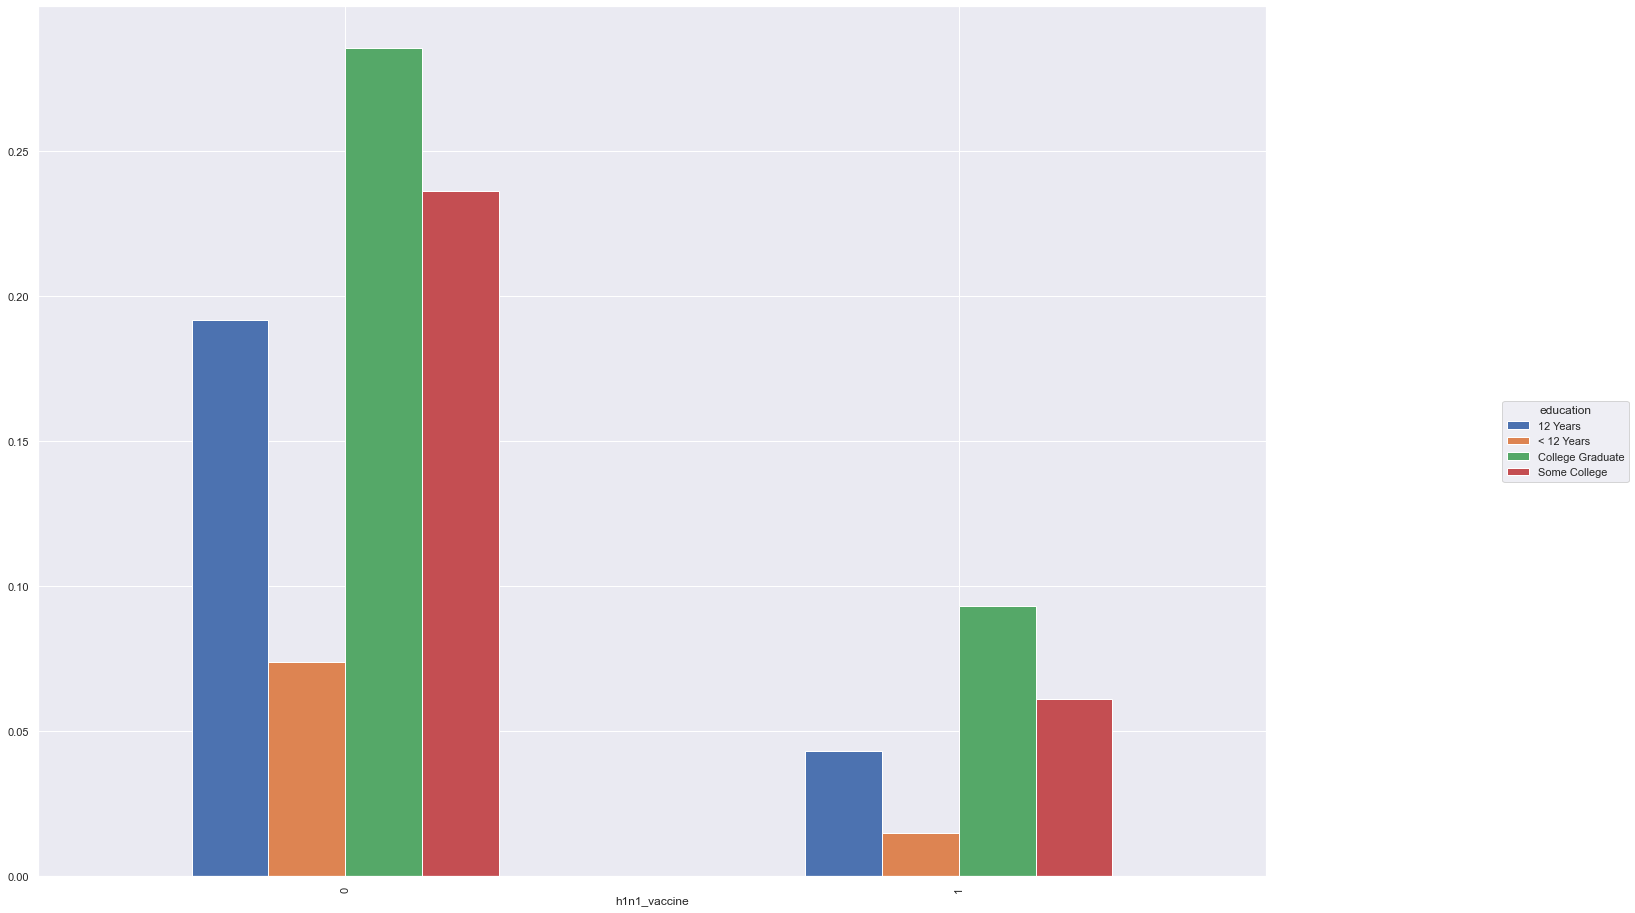

In [77]:
n_obs = df3.shape[0]

counts18 = (df3[['education','h1n1_vaccine']]
              .groupby(['education','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('education')
         )

ax = counts18.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='education')

In [78]:
counts17

education,12 Years,< 12 Years,College Graduate,Some College
seasonal_vaccine,,,,
0,0.130153,0.053357,0.185120,0.165762
1,0.104542,0.035609,0.193695,0.131763


In [79]:
counts18

education,12 Years,< 12 Years,College Graduate,Some College
h1n1_vaccine,,,,
0,0.191635,0.073988,0.285655,0.236268
1,0.043060,0.014977,0.093159,0.061257


## H13. Indivíduos que tem o costume de usar máscara tendem a vacinar-se mais

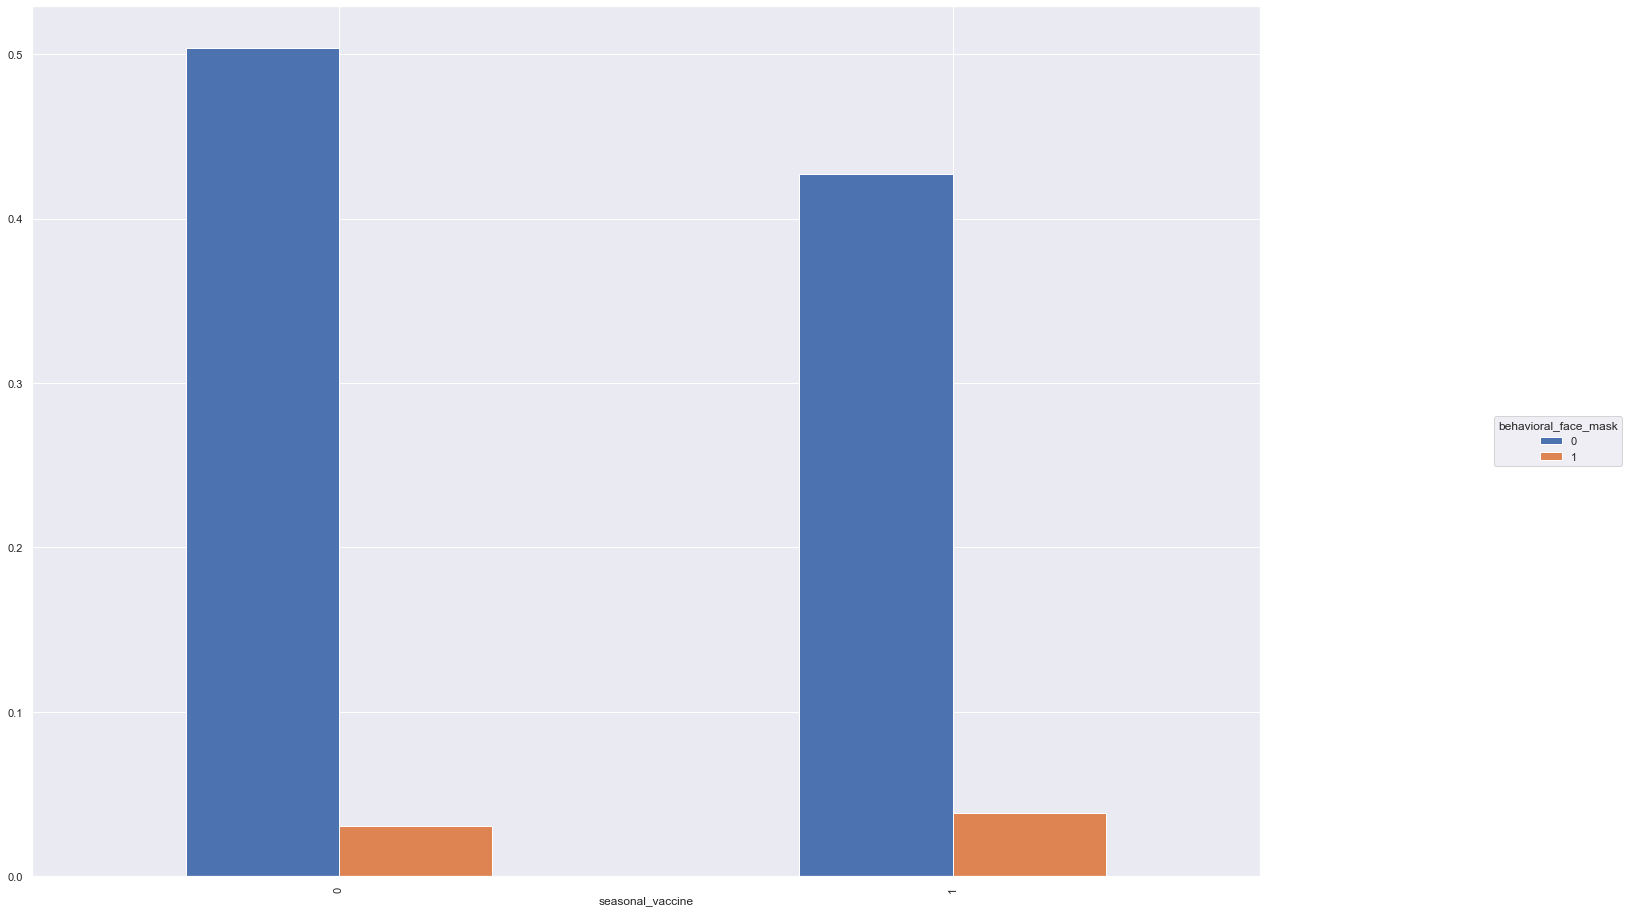

In [80]:
n_obs = df3.shape[0]

counts19 = (df3[['behavioral_face_mask','seasonal_vaccine']]
              .groupby(['behavioral_face_mask','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('behavioral_face_mask')
         )

ax = counts19.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='behavioral_face_mask')

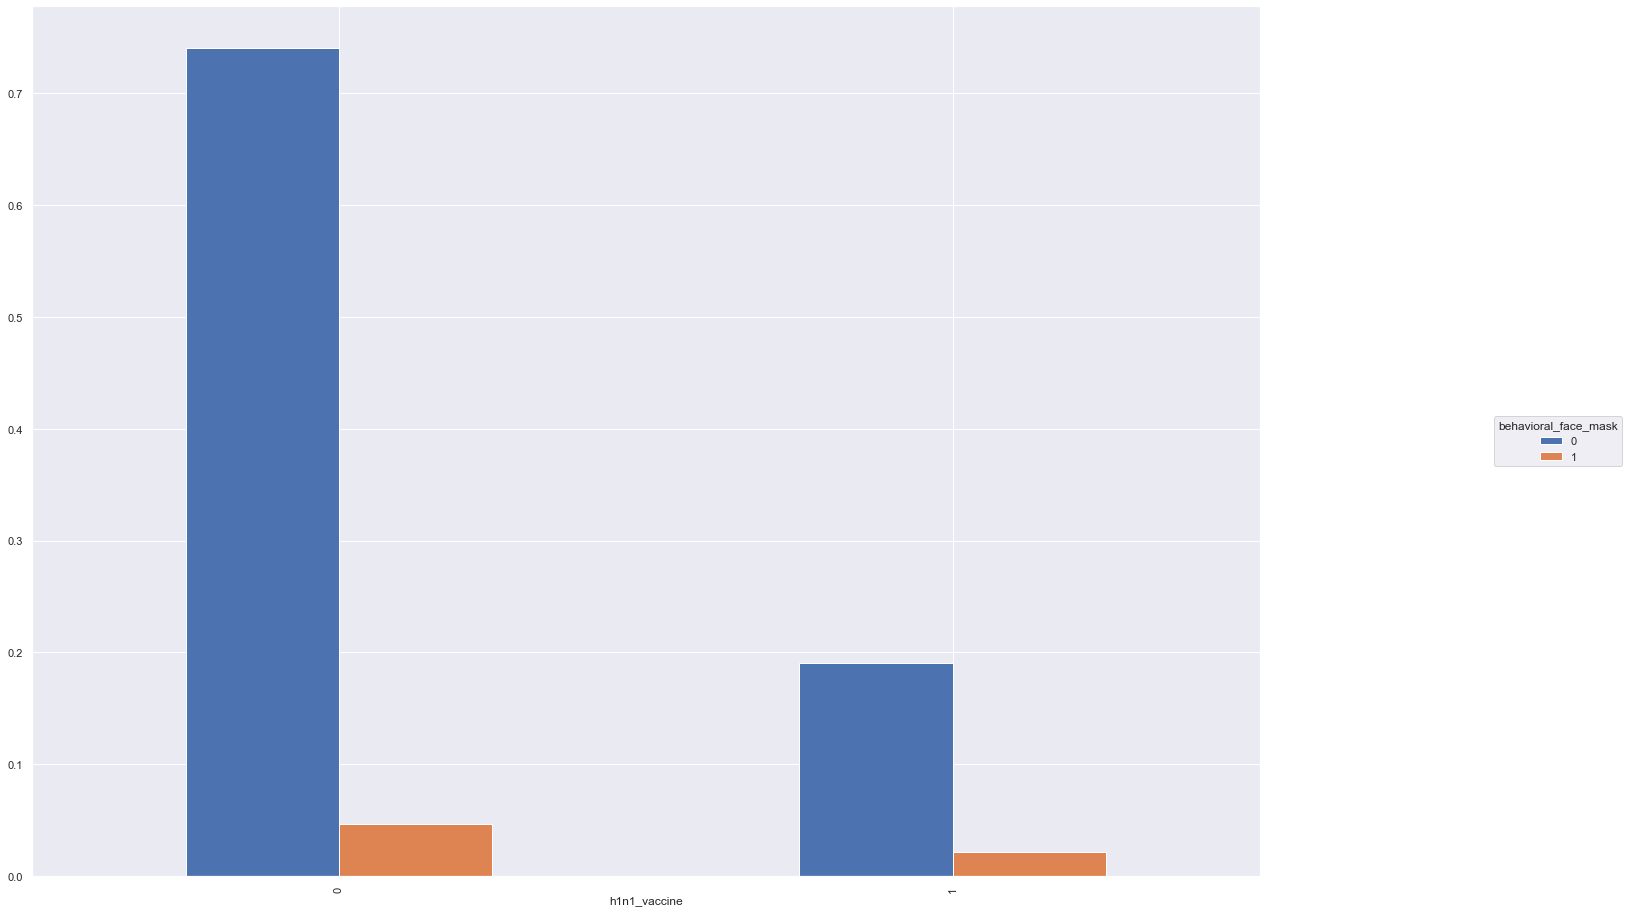

In [81]:
n_obs = df3.shape[0]

counts20 = (df3[['behavioral_face_mask','h1n1_vaccine']]
              .groupby(['behavioral_face_mask','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('behavioral_face_mask')
         )

ax = counts20.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='behavioral_face_mask')

In [82]:
counts19

behavioral_face_mask,0,1
seasonal_vaccine,,
0,0.503875,0.030516
1,0.427191,0.038417


In [83]:
counts20

behavioral_face_mask,0,1
h1n1_vaccine,,
0,0.740555,0.046991
1,0.190512,0.021942


## 14. Indivíduos com "Nível de Preocupação" menor quanto a contrair H1N1 tendem a vacinar-se menos

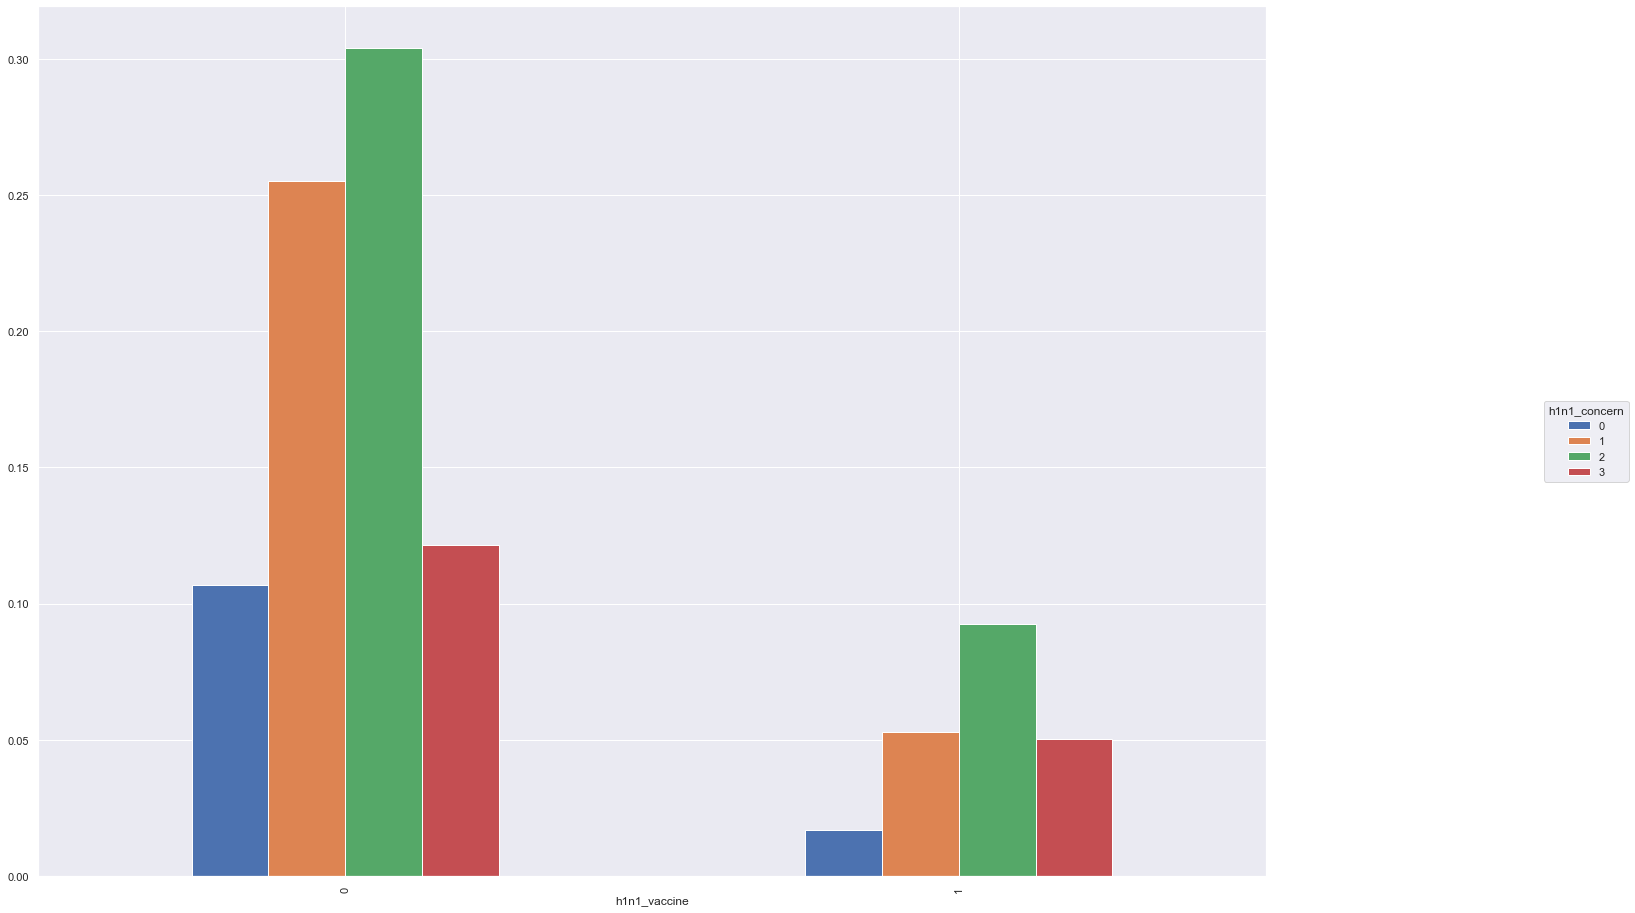

In [84]:
n_obs = df3.shape[0]

counts20 = (df3[['h1n1_concern','h1n1_vaccine']]
              .groupby(['h1n1_concern','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('h1n1_concern')
         )

ax = counts20.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='h1n1_concern')

In [85]:
counts20

h1n1_concern,0,1,2,3
h1n1_vaccine,,,,
0,0.106863,0.254989,0.304003,0.121691
1,0.016812,0.052795,0.092635,0.050212


## 15. Indivíduos que utilizam medicações antivirais tendem a vacinar-se mais

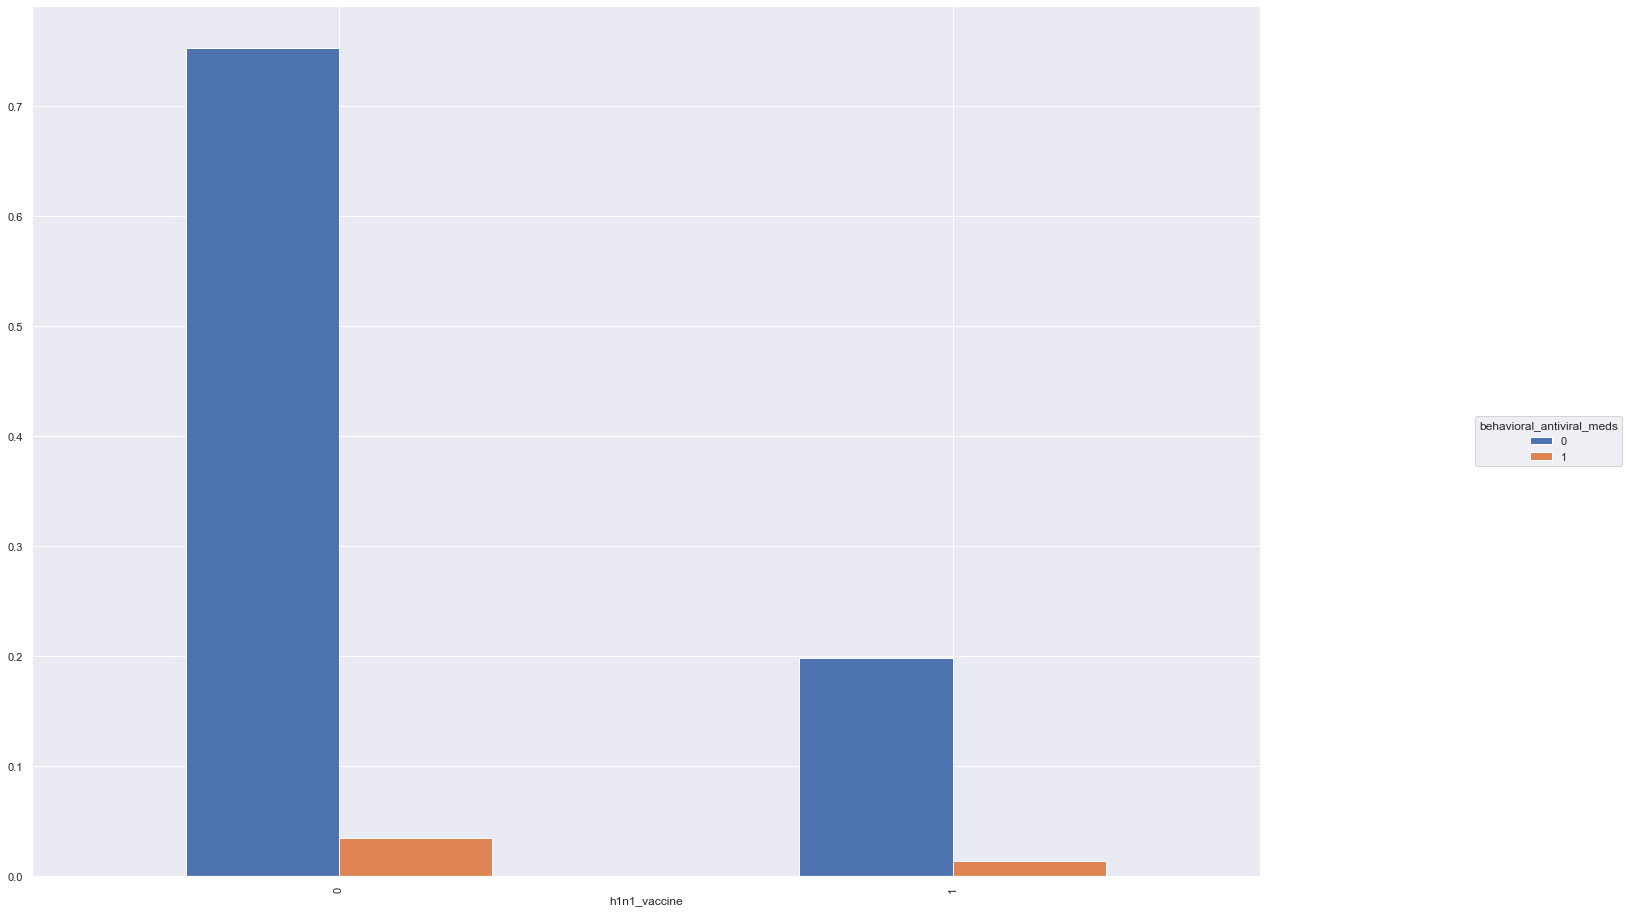

In [86]:
n_obs = df3.shape[0]

counts21 = (df3[['behavioral_antiviral_meds','h1n1_vaccine']]
              .groupby(['behavioral_antiviral_meds','h1n1_vaccine'])
              .size()
              .div(n_obs)
              .unstack('behavioral_antiviral_meds')
         )

ax = counts21.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='behavioral_antiviral_meds')

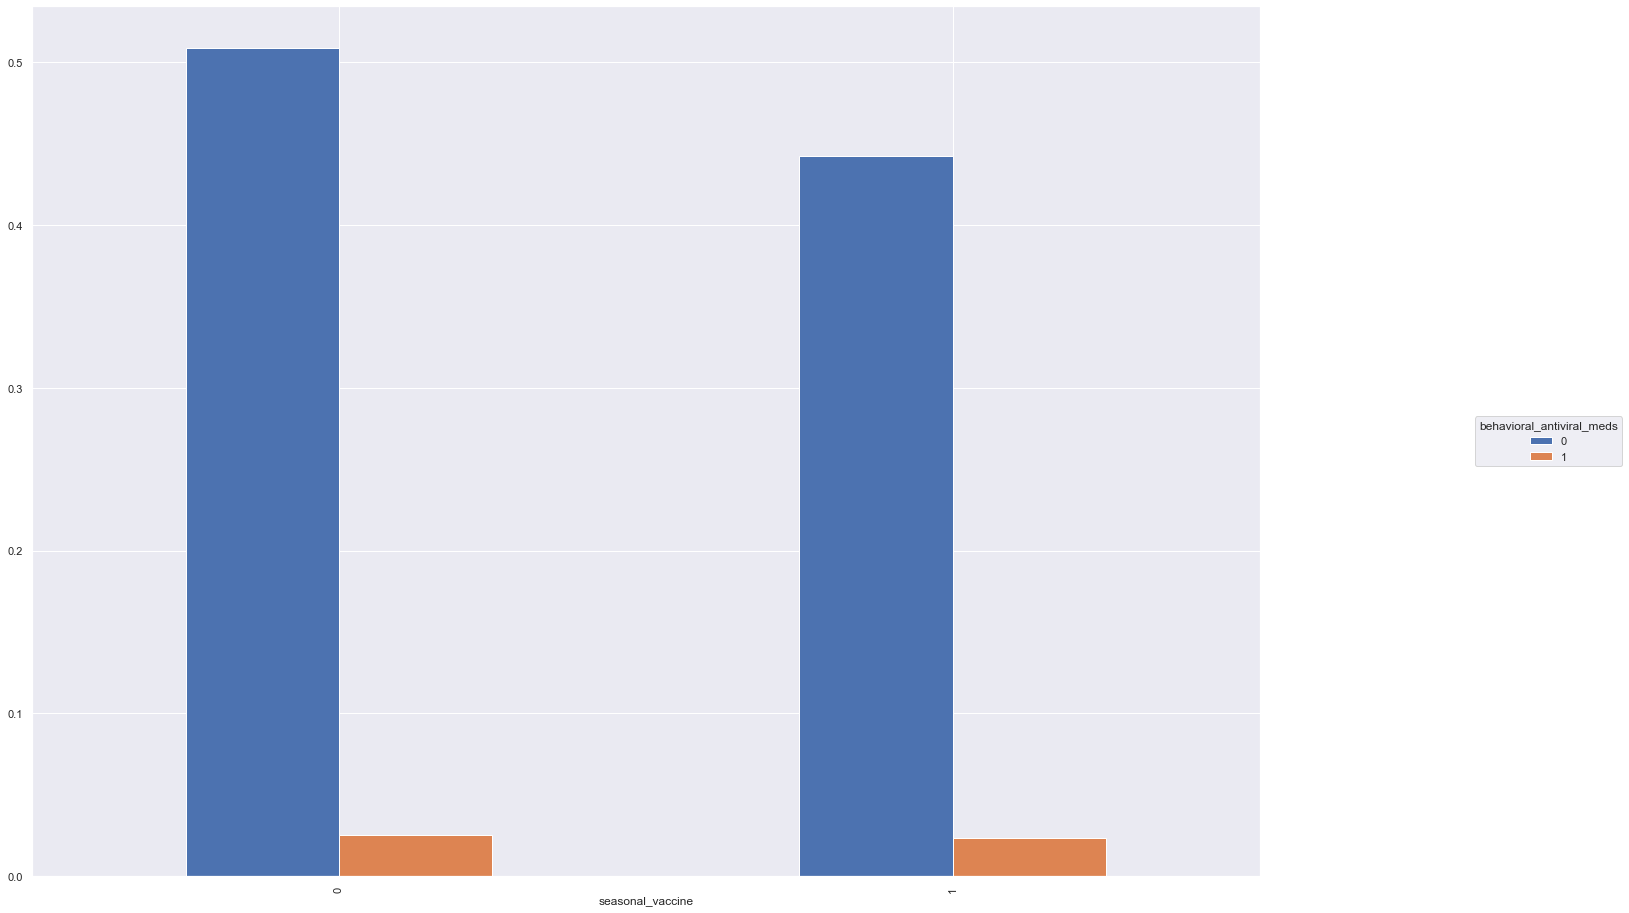

In [87]:
n_obs = df3.shape[0]

counts22 = (df3[['behavioral_antiviral_meds','seasonal_vaccine']]
              .groupby(['behavioral_antiviral_meds','seasonal_vaccine'])
              .size()
              .div(n_obs)
              .unstack('behavioral_antiviral_meds')
         )

ax = counts22.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='behavioral_antiviral_meds')

In [88]:
counts21

behavioral_antiviral_meds,0,1
h1n1_vaccine,,
0,0.752724,0.034822
1,0.198562,0.013891


In [89]:
counts22

behavioral_antiviral_meds,0,1
seasonal_vaccine,,
0,0.509005,0.025387
1,0.442281,0.023327


In [90]:
tab =[['Hipóteses', 'Conclusão', 'Relevância'],
['H1', 'Falsa', 'Alta'],
['H2', 'Falsa', 'Alta'],
['H3', 'Falsa', 'Alta'],
['H4', 'Verdade', 'Alta'],
['H5', 'Verdade', 'Media'],
['H6', 'Falsa', 'Media'],
['H7', 'Verdade', 'Media'],
['H8', 'Falsa', 'Media'],
['H9', 'Verdade', 'Media'],
['H10', 'Verdade', 'Media'],
['H11', 'Verdade', 'Alta'],
['H12', 'Verdade', 'Media'],
['H13', 'Há Excessões (V)', 'Media'],
['H14', 'Verdade', 'Baixa'],
['H15', 'Falso', 'Media']
      
]
print( tabulate( tab ) )

---------  ----------------  ----------
Hipóteses  Conclusão         Relevância
H1         Falsa             Alta
H2         Falsa             Alta
H3         Falsa             Alta
H4         Verdade           Alta
H5         Verdade           Media
H6         Falsa             Media
H7         Verdade           Media
H8         Falsa             Media
H9         Verdade           Media
H10        Verdade           Media
H11        Verdade           Alta
H12        Verdade           Media
H13        Há Excessões (V)  Media
H14        Verdade           Baixa
H15        Falso             Media
---------  ----------------  ----------


# 3.3 Análise Multivarida

#### 3.3.1 Numerical Variable

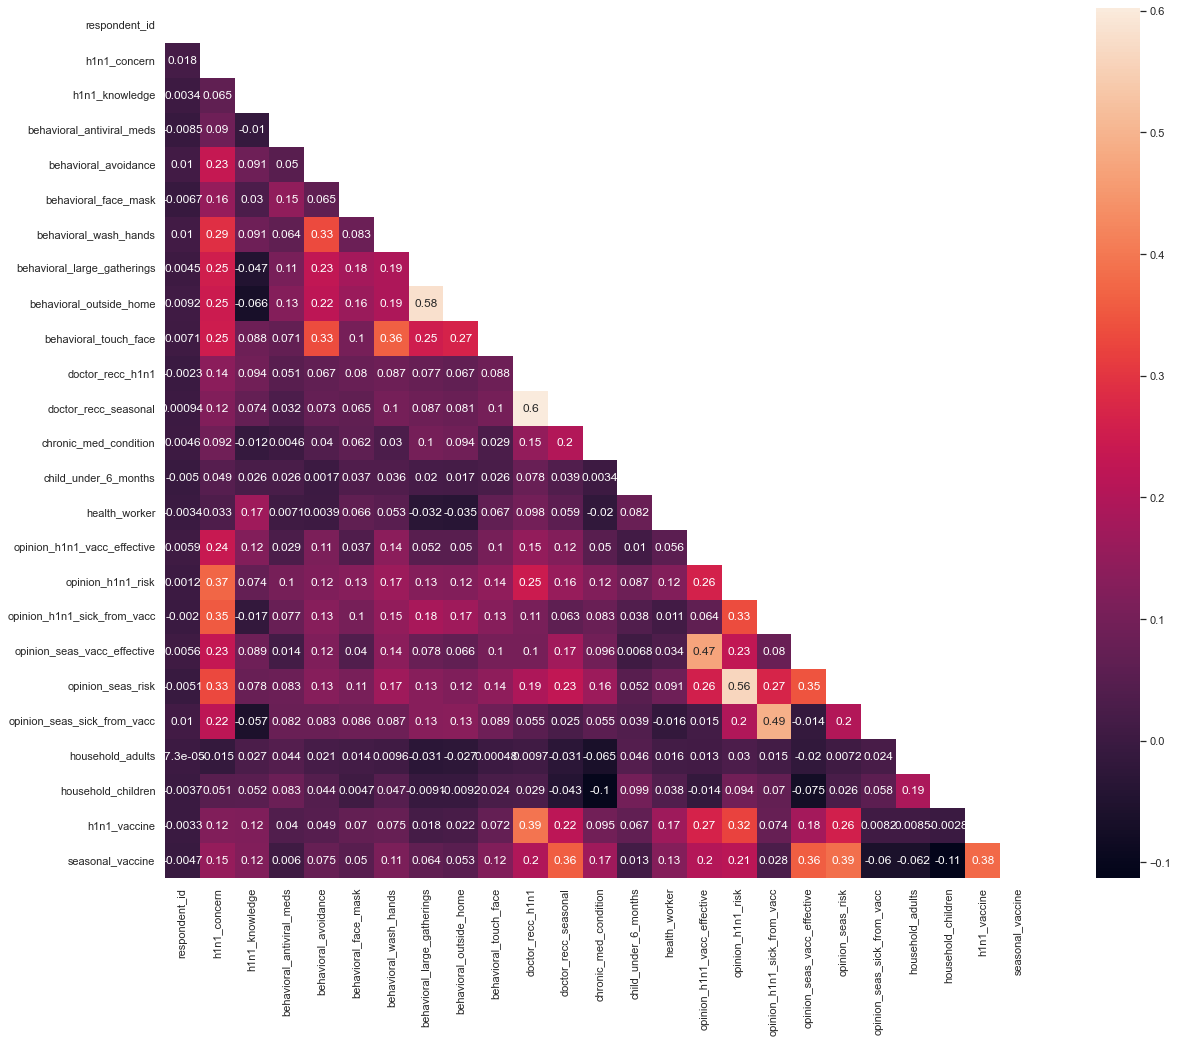

In [91]:
corr = num_attributes.corr( method = 'pearson')

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    ax = sns.heatmap(corr, mask=mask, square=True, annot = True)

#### 3.3.2 Categorical Variable

In [92]:
cat_attributes.columns

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'census_msa'],
      dtype='object')

In [93]:
#list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range (len (cat_attributes_list)):
    corr_list = []
    for j in range (len (cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        #correlation
        corr = cramer_v(df3[ref], df3[feat])
        
        #append a list
        corr_list.append (corr)
    
    #append a correlation list for each ref attributes
    corr_dict[ref] = corr_list


<AxesSubplot:>

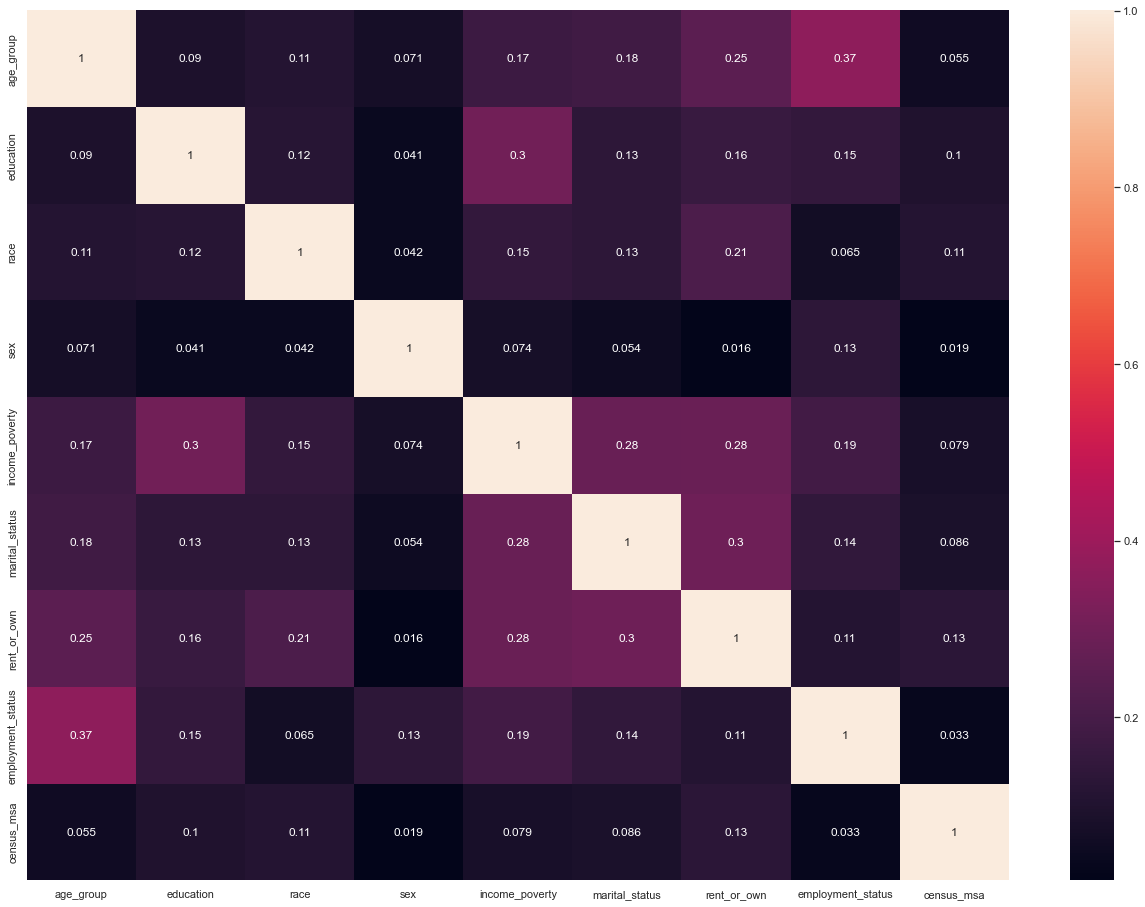

In [94]:
d = pd.DataFrame (corr_dict)
d = d.set_index (d.columns)

sns.heatmap (d, annot = True)